# HOMEWORK for Nick

- perform feature selection, add correlation heatmap, remove features with low correlation
- add some persistence with pickle, save the reduce dataset as a local CSV file to speed up iteration
- code cleanup: y_test_label should be y_test to make the variable naming more consistent with sample code
- add a section at the top of this notebook that describes the experiment, the dataset used, etc.

# FUTURE WORKS for subsequent projects
- consider using "Beautiful Soup" package to analyze HTTP text data
- use NLP for extracting text data from features like "http_uri_query" to analyze the contents of the text and extract meaningful information
- This project only used 2 classes (normal vs attack), consider using multi-class classification so you can determine what specific type of attack (brute force, DoS, etc)
- look into the "prompt engineering" functionality in ChatGPT.  This is a way to instruct ChatGPT to provide better quality python code.


# Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score    #for cross fold validation
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing   import StandardScaler

from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.svm             import SVC    
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.naive_bayes     import GaussianNB, MultinomialNB, BernoulliNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import SMOTE

# Miscellaneous packages
import time                          #for calculating elapsed time for training tasks
import os                            #for checking if file exists
import socket                        #for getting FQDN of local machine
import math                          #square root function
import sys

# Packages for Ensemble Learning
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression  #used by stacking models
from sklearn.tree import DecisionTreeClassifier      #used by stacking models
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb                                #not part of sklearn, need to install with: pip install xgboost

# Define functions

In [2]:
# function to show missing values in dataset

def get_type_missing(df):
    df_types = pd.DataFrame()
    df_types['data_type'] = df.dtypes
    df_types['missing_values'] = df.isnull().sum()
    return df_types.sort_values(by='missing_values', ascending=False)

In [3]:
# function to create a confusion matrix

def visualize_confusion_matrix(y_test_label, y_pred):
    #
    ## Calculate accuracy
    #accuracy = accuracy_score(y_test_label, y_pred)
    #print("Accuracy:", accuracy)
    #
    # Confusion Matrix
    cm = confusion_matrix(y_test_label, y_pred)
    #
    # visualize confusion matrix with more detailed labels
    # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    #
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(3.5, 2.0))  #default figsize is 6.4" wide x 4.8" tall, shrink to 3.5" wide 2.0" tall
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    # use the .ravel function to pull out TN,TP,FN,TP
    # https://analytics4all.org/2020/05/07/python-confusion-matrix/
    TN, FP, FN, TP = cm.ravel()
    
    # calculate different metrics
    Accuracy = (( TP + TN) / ( TP + TN + FP + FN))
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    GeometricMean = math.sqrt(Sensitivity * Specificity)

    # Precision is the ratio of true positive predictions to the total number of positive predictions made by the model
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    precision = precision_score(y_test_label, y_pred, average='weighted')  
    
    # Recall is the ratio of true positive predictions to the total number of actual positive instances in the data.
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    recall = recall_score(y_test_label, y_pred, average='weighted') 
    
    # F1-score is a metric that considers both precision and recall, providing a balance between the two. 
    # average=binary for  binary classification models, average=micro for multiclass classification, average=weighted to match classification_report
    f1 = f1_score(y_test_label, y_pred, average='weighted')
    
    # add details below graph to help interpret results
    print('\n\n')
    print('Confusion matrix\n\n', cm)
    print('\nTrue Negatives  (TN) = ', TN)
    print('False Positives (FP) = ', FP)
    print('False Negatives (FN) = ', FN)
    print('True Positives  (TP) = ', TP)
    print ('\n')
    print ("Accuracy:       ", Accuracy)
    print ("Sensitivity:    ", Sensitivity)
    print ("Specificity:    ", Specificity)
    print ("Geometric Mean: ", GeometricMean)
    print ('\n')
    print ("Precision:       ", precision)
    print ("Recall:          ", recall)
    print ("f1-score:        ", f1)
    
    print('\n------------------------------------------------\n')
    # We want TN and TP to be approximately equal, because this indicates the dataset is well balanced.
    # If TN and TP are very different, it indicates imbalanced data, which can lead to low accuracy due to overfitting
    #if (TN/TP*100 < 40 or TN/TP*100 > 60):   #we want TN and TP to be approximately 50%, if the values are below 40% or over 60%, generate a warning
    #    print("WARNING: the confusion matrix shows that TN and TP are very imbalanced, may lead to low accuracy!")
    #
    return cm
    
    



In [4]:
# function to report on model accuracy (TP, FP, FN, FP), precision, recall, f1-score

def model_classification_report(cm, y_test_label, y_pred):
    report = classification_report(y_test_label, y_pred, digits=4)
    print('\n')
    print("Classification Report: \n", report)
    print('\n\n\n')



In [5]:
# # function to create confusion matrix

# # code to put in python file named functions.py
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import accuracy_score, confusion_matrix

# def calculate_accuracy_and_plot_confusion_matrix(y_test_label, y_pred):
#     """
#     Calculate accuracy and plot a confusion matrix as a heatmap.

#     Parameters:
#     y_test_label (array-like): True labels of the test data.
#     y_pred (array-like): Predicted labels for the test data.

#     Returns:
#     float: The accuracy score.
#     """

#     # Calculate accuracy
#     accuracy = accuracy_score(y_test_label, y_pred)

#     # Create confusion matrix
#     cm = confusion_matrix(y_test_label, y_pred)

#     # Plot confusion matrix as a heatmap
#     plt.figure(figsize=(4, 2))
#     sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
#     plt.xlabel("Predicted Labels")
#     plt.ylabel("True Labels")
#     plt.title("Confusion Matrix")
#     plt.show()

#     return accuracy

# # Example usage:
# # accuracy_score = calculate_accuracy_and_plot_confusion_matrix(y_test_label, y_pred)
# # print("Accuracy:", accuracy_score)


# Initialize variables

In [6]:
# initialize variables to avoid undef errors

accuracy_lr_undersampled_unoptimized  = 0
accuracy_lr_undersampled_optimized    = 0
accuracy_dt_undersampled_unoptimized  = 0
accuracy_dt_undersampled_optimized    = 0
accuracy_ds_undersampled_unoptimized  = 0
accuracy_ds_undersampled_optimized    = 0
accuracy_rf_undersampled_unoptimized  = 0
accuracy_rf_undersampled_optimized    = 0
accuracy_nb_undersampled_unoptimized  = 0
accuracy_nb_undersampled_optimized    = 0
accuracy_svm_undersampled_unoptimized = 0
accuracy_svm_undersampled_optimized   = 0
accuracy_knn_undersampled_unoptimized = 0
accuracy_knn_undersampled_optimized   = 0
accuracy_mlp_undersampled_unoptimized = 0
accuracy_mlp_undersampled_optimized   = 0
accuracy_gb_undersampled_unoptimized  = 0
accuracy_gb_undersampled_optimized    = 0
accuracy_xgb_undersampled_unoptimized = 0
accuracy_xgb_undersampled_optimized   = 0

best_params_lr                        = ""
best_params_dt                        = ""
best_params_ds                        = ""
best_params_rf                        = ""
best_params_nb                        = ""
best_params_svm                       = ""
best_params_knn                       = ""
best_params_mlp                       = ""
best_params_gb                        = ""
best_params_xgb                       = ""

accuracy_ensemble_voting              = 0
accuracy_ensemble_stacking            = 0
accuracy_ensemble_boosting            = 0
accuracy_ensemble_bagging             = 0

cv_count                              = 10  #number of cross-validation folds

In [7]:
# start a timer so we can calculate the total runtime of this notebook
notebook_start_time = time.time()  #seconds since epoch

# Load dataset

In [8]:
# define CSV source file

filename = 'DNN-EdgeIIoT-dataset.csv'
LAN_location = 'http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'  #high speed local copy on LAN
WAN_location = 'http://datasets.nyx.ca:8081/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL'   #accessible to entire internet



# Get the FQDN of the local machine
fqdn = socket.getfqdn()
ipv4_address = socket.gethostbyname(socket.gethostname())
print(f"Fully Qualified Domain Name (FQDN):{fqdn}, IPv4 address:{ipv4_address}")
if ( "nyx.local" in fqdn ):
    # If inside the LAN, grab the local copy of the dataset
    print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{LAN_location}/{filename}")
    dataset = f"{LAN_location}/{filename}"
else:
    # If not inside the LAN, grab the dataset from an internet-accessible URL
    print(f"Detected Fully Qualified Domain Name of {fqdn}, dataset source is:\n{WAN_location}/{filename}")
    dataset = f"{WAN_location}/{filename}"

    
print(f"Loading dataset from {dataset}")
df = pd.read_csv(dataset)

Fully Qualified Domain Name (FQDN):DESKTOP-SNBGTFL.nyx.local, IPv4 address:192.168.14.136
Detected Fully Qualified Domain Name of DESKTOP-SNBGTFL.nyx.local, dataset source is:
http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL/DNN-EdgeIIoT-dataset.csv
Loading dataset from http://datasets.nyx.local:80/datasets/Edge-IIoTset2023/Selected_dataset_for_ML_and_DL/DNN-EdgeIIoT-dataset.csv


C:\Users\njeffrey\AppData\Local\Temp\ipykernel_17208\115976897.py:24: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset)


In [9]:
print(f"Dropping rows from the dataset during debugging to speed up this notebook - turn this off when finished debugging!")

# cut dataset in half if > 2 million rows
if ( len(df) > 2000000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# cut dataset in half if > 1 million rows
if ( len(df) > 1000000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# cut dataset in half if > 0.5 million rows
if ( len(df) > 500000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# cut dataset in half if > 0.5 million rows
if ( len(df) > 500000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# cut dataset in half if > 250,000 rows
if ( len(df) > 250000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# notebook runtime ~45 minutes with this many rows
# cut dataset in half if > 100,000 rows
if ( len(df) > 100000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# notebook runtime ~13 minutes with this many rows
# cut dataset in half if > 50,000 rows
if ( len(df) > 50000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")

# notebook runtime ~5 minutes with this many rows
# cut dataset in half if > 25,000 rows
if ( len(df) > 25000):
    print(f"Original size of dataset is", len(df), " rows")
    df.drop(df.index[::2], inplace=True)
    print(f"Dataset size after dropping all the even-numbered rows is", len(df), " rows")


Dropping rows from the dataset during debugging to speed up this notebook - turn this off when finished debugging!
Original size of dataset is 2219201  rows
Dataset size after dropping all the even-numbered rows is 1109600  rows
Original size of dataset is 1109600  rows
Dataset size after dropping all the even-numbered rows is 554800  rows
Original size of dataset is 554800  rows
Dataset size after dropping all the even-numbered rows is 277400  rows
Original size of dataset is 277400  rows
Dataset size after dropping all the even-numbered rows is 138700  rows
Original size of dataset is 138700  rows
Dataset size after dropping all the even-numbered rows is 69350  rows
Original size of dataset is 69350  rows
Dataset size after dropping all the even-numbered rows is 34675  rows
Original size of dataset is 34675  rows
Dataset size after dropping all the even-numbered rows is 17337  rows


In [10]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (17337, 63)


In [11]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

The entire notebook runtime so far is 4 minutes


# Exploratory Data Analysis (EDA)

In [12]:
# take a quick look at the data
df.head()

frame.time    ip.src_host    ip.dst_host  \
127   2021 11:44:16.240051000   192.168.0.101  192.168.0.128   
255   2021 11:44:24.267046000   192.168.0.101  192.168.0.128   
383   2021 11:44:32.310917000   192.168.0.128  192.168.0.101   
511   2021 11:44:42.310422000   192.168.0.128  192.168.0.101   
639   2021 11:44:48.414713000   192.168.0.101  192.168.0.128   

    arp.dst.proto_ipv4  arp.opcode  arp.hw.size arp.src.proto_ipv4  \
127                  0         0.0          0.0                  0   
255                  0         0.0          0.0                  0   
383                  0         0.0          0.0                  0   
511                  0         0.0          0.0                  0   
639                  0         0.0          0.0                  0   

     icmp.checksum  icmp.seq_le  icmp.transmit_timestamp  ...  mqtt.proto_len  \
127            0.0          0.0                      0.0  ...             0.0   
255            0.0          0.0                      0.0  ...             0.0   
383            0.0          0.0                      0.0  ...             0.0   
511            0.0          0.0                      0.0  ...             0.0   
639            0.0          0.0                      0.0  ...             0.0   

    mqtt.protoname  mqtt.topic mqtt.topic_len mqtt.ver mbtcp.len  \
127              0           0            0.0      0.0       0.0   
255              0           0            0.0      0.0       0.0   
383              0           0            0.0      0.0       0.0   
511              0           0            0.0      0.0       0.0   
639              0           0            0.0      0.0       0.0   

    mbtcp.trans_id mbtcp.unit_id  Attack_label  Attack_type  
127            0.0           0.0             0       Normal  
255            0.0           0.0             0       Normal  
383            0.0           0.0             0       Normal  
511            0.0           0.0             0       Normal  
639            0.0           0.0             0       Normal  

[5 rows x 63 columns]

In [13]:
# Display all the data rather than just a portion
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [14]:
# check for any missing values in dataset
df.isna().sum()

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64

In [15]:
# check for any missing datatypes
get_type_missing(df)

data_type  missing_values
frame.time               object               0
mqtt.conflags           float64               0
tcp.srcport              object               0
udp.port                float64               0
udp.stream              float64               0
...                         ...             ...
tcp.connection.synack   float64               0
tcp.dstport             float64               0
tcp.flags               float64               0
tcp.flags.ack           float64               0
Attack_type              object               0

[63 rows x 2 columns]

In [16]:
df.describe()

arp.opcode   arp.hw.size  icmp.checksum   icmp.seq_le  \
count  17337.000000  17337.000000   17337.000000  17337.000000   
mean       0.003057      0.014535    1734.763627   1927.268155   
std        0.065703      0.294968    8501.298575   8962.836449   
min        0.000000      0.000000       0.000000      0.000000   
25%        0.000000      0.000000       0.000000      0.000000   
50%        0.000000      0.000000       0.000000      0.000000   
75%        0.000000      0.000000       0.000000      0.000000   
max        2.000000      6.000000   65373.000000  65511.000000   

       icmp.transmit_timestamp  icmp.unused  http.content_length  \
count             1.733700e+04      17337.0         17337.000000   
mean              4.416502e+03          0.0             5.093442   
std               5.815210e+05          0.0            60.040038   
min               0.000000e+00          0.0             0.000000   
25%               0.000000e+00          0.0             0.000000   
50%               0.000000e+00          0.0             0.000000   
75%               0.000000e+00          0.0             0.000000   
max               7.656889e+07          0.0          1465.000000   

       http.response  http.tls_port       tcp.ack  ...      mqtt.len  \
count   17337.000000        17337.0  1.733700e+04  ...  17337.000000   
mean        0.014189            0.0  2.283297e+07  ...      2.041299   
std         0.118274            0.0  1.646465e+08  ...      7.761844   
min         0.000000            0.0  0.000000e+00  ...      0.000000   
25%         0.000000            0.0  1.000000e+00  ...      0.000000   
50%         0.000000            0.0  6.000000e+00  ...      0.000000   
75%         0.000000            0.0  5.900000e+01  ...      0.000000   
max         1.000000            0.0  2.139918e+09  ...     39.000000   

       mqtt.msg_decoded_as  mqtt.msgtype  mqtt.proto_len  mqtt.topic_len  \
count              17337.0  17337.000000    17337.000000    17337.000000   
mean                   0.0      0.786699        0.152045        0.927496   
std                    0.0      2.773099        0.764915        4.626110   
min                    0.0      0.000000        0.000000        0.000000   
25%                    0.0      0.000000        0.000000        0.000000   
50%                    0.0      0.000000        0.000000        0.000000   
75%                    0.0      0.000000        0.000000        0.000000   
max                    0.0     14.000000        4.000000       24.000000   

           mqtt.ver     mbtcp.len  mbtcp.trans_id  mbtcp.unit_id  Attack_label  
count  17337.000000  17337.000000    17337.000000   17337.000000  17337.000000  
mean       0.152045      0.003115        0.013151       0.000115      0.271962  
std        0.764915      0.289987        1.227403       0.010740      0.444983  
min        0.000000      0.000000        0.000000       0.000000      0.000000  
25%        0.000000      0.000000        0.000000       0.000000      0.000000  
50%        0.000000      0.000000        0.000000       0.000000      0.000000  
75%        0.000000      0.000000        0.000000       0.000000      1.000000  
max        4.000000     27.000000      122.000000       1.000000      1.000000  

[8 rows x 43 columns]

In [17]:
# look at all the datatypes of that are objects, in case any can be converted to integers
df.describe(include='object')

frame.time    ip.src_host    ip.dst_host arp.dst.proto_ipv4  \
count           17337          17337          17337              17337   
unique          17235           1076            437                  8   
top     192.168.0.128  192.168.0.128  192.168.0.128                  0   
freq               96           7541           7437              13165   

       arp.src.proto_ipv4  http.file_data  http.request.uri.query  \
count               17337         17337.0                 17337.0   
unique                  8            42.0                    87.0   
top                     0             0.0                     0.0   
freq                12440         15545.0                 16313.0   

        http.request.method  http.referer  http.request.full_uri  \
count               17337.0       17337.0                17337.0   
unique                  6.0           5.0                  195.0   
top                     0.0           0.0                    0.0   
freq                15033.0       16441.0                15033.0   

        http.request.version tcp.options tcp.payload  tcp.srcport  \
count                17337.0       17337       17337      17337.0   
unique                   5.0        2198        2315       6593.0   
top                      0.0           0           0       1883.0   
freq                 15033.0       11485       10064       5135.0   

        dns.qry.name.len mqtt.conack.flags mqtt.msg mqtt.protoname mqtt.topic  \
count              17337             17337    17337          17337      17337   
unique                 9                 5       86              4          4   
top                    0                 0        0              0          0   
freq               15417             11945    11952          11963      11952   

       Attack_type  
count        17337  
unique          15  
top         Normal  
freq         12622

In [18]:
# look at the values in all of the features

feature_names = df.columns.tolist()

for feature_name in feature_names:
    if feature_name in df.columns:
        print('\n')
        print(f"------------------")
        print(f"{feature_name}")
        print(f"------------------")
        print(df[feature_name].value_counts())




------------------
frame.time
------------------
192.168.0.128                96
0.0                           5
6.0                           4
 2021 20:41:43.020677000      1
 2021 20:41:51.125102000      1
                             ..
 2021 20:06:35.000076000      1
 2021 20:06:37.010898000      1
 2021 20:06:38.530847000      1
 2021 20:06:39.914185000      1
 2021 23:24:32.716408000      1
Name: frame.time, Length: 17235, dtype: int64


------------------
ip.src_host
------------------
192.168.0.128     7541
192.168.0.101     5206
0                 2248
192.168.0.170     1253
0.0.0.0             15
                  ... 
2.220.180.106        1
101.60.160.172       1
103.40.97.143        1
10.220.141.250       1
95.77.69.81          1
Name: ip.src_host, Length: 1076, dtype: int64


------------------
ip.dst_host
------------------
192.168.0.128      7437
192.168.0.101      5175
0                  2968
192.168.0.170      1161
0                   128
                   ... 
123.

In [19]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (17337, 63)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337 entries, 127 to 2219135
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   frame.time                 17337 non-null  object 
 1   ip.src_host                17337 non-null  object 
 2   ip.dst_host                17337 non-null  object 
 3   arp.dst.proto_ipv4         17337 non-null  object 
 4   arp.opcode                 17337 non-null  float64
 5   arp.hw.size                17337 non-null  float64
 6   arp.src.proto_ipv4         17337 non-null  object 
 7   icmp.checksum              17337 non-null  float64
 8   icmp.seq_le                17337 non-null  float64
 9   icmp.transmit_timestamp    17337 non-null  float64
 10  icmp.unused                17337 non-null  float64
 11  http.file_data             17337 non-null  object 
 12  http.content_length        17337 non-null  float64
 13  http.request.uri.query     17337 non-null 

# Data preprocessing

## Fix up feature names

In [21]:
# look at the column names
df.columns

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [22]:
print(df['frame.time'].value_counts().head())

print("\nNull Values:")
print(df['frame.time'].isna().sum())

192.168.0.128                96
0.0                           5
6.0                           4
 2021 20:41:43.020677000      1
 2021 20:41:51.125102000      1
Name: frame.time, dtype: int64

Null Values:
0


In [23]:
# converting to datetime
def convert_to_datetime(value):
    try:
         return pd.to_datetime(value)
    except:
        return np.nan
       
    
df['frame.time'] = df['frame.time'].apply(convert_to_datetime)

In [24]:
# Validating IP address

print(df['ip.src_host'].value_counts().head())
print('_________________________________________________________')
print(df['ip.dst_host'].value_counts().head())
print('_________________________________________________________')
print(df['arp.src.proto_ipv4'].value_counts().head())
print('_________________________________________________________')
print(df['arp.dst.proto_ipv4'].value_counts().head())

192.168.0.128    7541
192.168.0.101    5206
0                2248
192.168.0.170    1253
0.0.0.0            15
Name: ip.src_host, dtype: int64
_________________________________________________________
192.168.0.128    7437
192.168.0.101    5175
0                2968
192.168.0.170    1161
0                 128
Name: ip.dst_host, dtype: int64
_________________________________________________________
0                12440
0                 4793
0.0                 62
192.168.0.1         22
192.168.0.128       10
Name: arp.src.proto_ipv4, dtype: int64
_________________________________________________________
0                13165
0                 4025
192.168.0.128      107
192.168.0.147       10
192.168.0.1          9
Name: arp.dst.proto_ipv4, dtype: int64


In [25]:
# just for fun explore these values in the http.file_data column
#df[df['Attack_label'] == 1]['http.file_data'].value_counts()


In [26]:
df['mqtt.topic'].value_counts()

0                           11952
0.0                          4665
Temperature_and_Humidity      670
0.0                            50
Name: mqtt.topic, dtype: int64

In [27]:
df['mqtt.protoname'].value_counts()

0       11963
0.0      4665
MQTT      659
0.0        50
Name: mqtt.protoname, dtype: int64

In [28]:
df['dns.qry.name.len'].value_counts()

0                         15417
0                          1857
0.0                          49
0.debian.pool.ntp.org         4
1.debian.pool.ntp.org         3
2.debian.pool.ntp.org         3
3.debian.pool.ntp.org         2
_googlecast._tcp.local        1
1.0                           1
Name: dns.qry.name.len, dtype: int64

In [29]:
df['http.request.method'].value_counts()

0.0      15033
0         1510
0.0        546
GET        236
POST        11
TRACE        1
Name: http.request.method, dtype: int64

- exploring the target dataset

In [30]:
# how many 0 (normal) and 1 (attack) values do we have?
df['Attack_label'].value_counts()

0    12622
1     4715
Name: Attack_label, dtype: int64

## Visualization

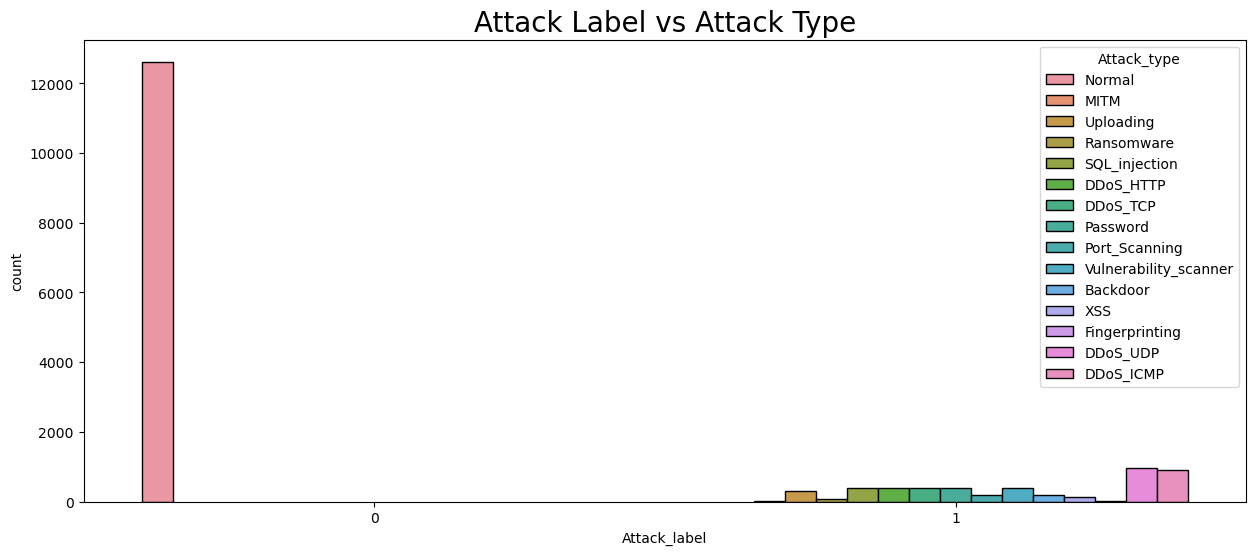

In [31]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='Attack_label', hue='Attack_type', edgecolor='black', linewidth=1)
plt.title('Attack Label vs Attack Type', fontsize=20)
plt.show()

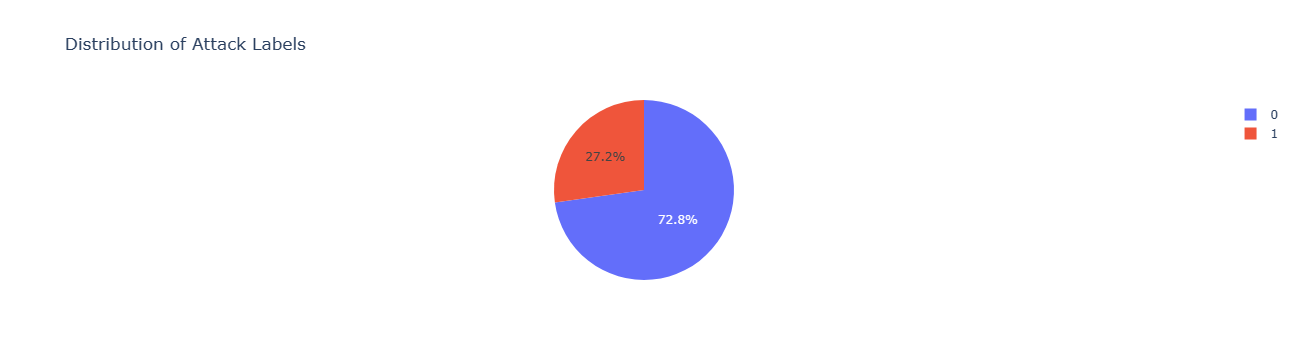

In [32]:
import plotly.express as px

fig = px.pie(df, names='Attack_label', title='Distribution of Attack Labels')
fig.show()


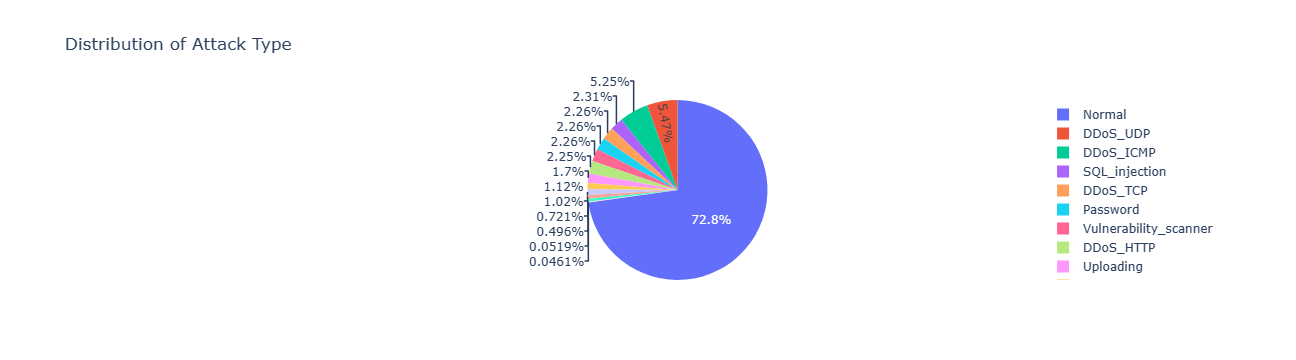

In [33]:
fig = px.pie(df, names='Attack_type', title='Distribution of Attack Type')
fig.show()


- class imbalance issue - this can cause the machine learning model to result in biased results

## Drop features 
Now using our domain knowledge we will only select useful features from our dataset and drop the rest

In [34]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (17337, 63)


In [35]:
# Identifying columns that are entirely NaN (empty) or have all zero values
empty_or_zero_columns = df.columns[(df.isnull().all())
| (df == 0).all()   | (df == 1).all() | (df == 1.0).all()
| (df == 0.0).all() | (df == 2).all() | (df == 2.0).all()]

# Displaying the identified columns
empty_features = empty_or_zero_columns.tolist()

print("These columns are all empty features:")
print(empty_features)


for feature in empty_features:
  if feature in df.columns:
    df.drop(feature, axis=1, inplace=True)
    print("Dropping empty feature:", feature)

These columns are all empty features:
['icmp.unused', 'http.tls_port', 'dns.qry.type', 'mqtt.msg_decoded_as']
Dropping empty feature: icmp.unused
Dropping empty feature: http.tls_port
Dropping empty feature: dns.qry.type
Dropping empty feature: mqtt.msg_decoded_as


In [36]:
# show the columns to confirm the features have been dropped
df.head()

frame.time    ip.src_host    ip.dst_host  \
127 2021-01-01 11:44:16.240051  192.168.0.101  192.168.0.128   
255 2021-01-01 11:44:24.267046  192.168.0.101  192.168.0.128   
383 2021-01-01 11:44:32.310917  192.168.0.128  192.168.0.101   
511 2021-01-01 11:44:42.310422  192.168.0.128  192.168.0.101   
639 2021-01-01 11:44:48.414713  192.168.0.101  192.168.0.128   

    arp.dst.proto_ipv4  arp.opcode  arp.hw.size arp.src.proto_ipv4  \
127                  0         0.0          0.0                  0   
255                  0         0.0          0.0                  0   
383                  0         0.0          0.0                  0   
511                  0         0.0          0.0                  0   
639                  0         0.0          0.0                  0   

     icmp.checksum  icmp.seq_le  icmp.transmit_timestamp  ... mqtt.proto_len  \
127            0.0          0.0                      0.0  ...            0.0   
255            0.0          0.0                      0.0  ...            0.0   
383            0.0          0.0                      0.0  ...            0.0   
511            0.0          0.0                      0.0  ...            0.0   
639            0.0          0.0                      0.0  ...            0.0   

     mqtt.protoname mqtt.topic mqtt.topic_len mqtt.ver mbtcp.len  \
127               0          0            0.0      0.0       0.0   
255               0          0            0.0      0.0       0.0   
383               0          0            0.0      0.0       0.0   
511               0          0            0.0      0.0       0.0   
639               0          0            0.0      0.0       0.0   

    mbtcp.trans_id  mbtcp.unit_id  Attack_label  Attack_type  
127            0.0            0.0             0       Normal  
255            0.0            0.0             0       Normal  
383            0.0            0.0             0       Normal  
511            0.0            0.0             0       Normal  
639            0.0            0.0             0       Normal  

[5 rows x 59 columns]

In [37]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (17337, 59)


In [38]:
# drop these features

feature_names = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4",
                "http.file_data","http.request.full_uri","icmp.transmit_timestamp",
                "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",
                "tcp.dstport", "udp.port", "mqtt.msg", "icmp.unused", "http.tls_port", 'dns.qry.type', 
                'dns.retransmit_request_in', "mqtt.msg_decoded_as", "mbtcp.trans_id", "mbtcp.unit_id", "http.request.method", "http.referer", 
                "http.request.version", "dns.qry.name.len", "mqtt.conack.flags", "mqtt.protoname", "mqtt.topic"]

# potential_drop_list = ['arp.opcode']

for feature_name in feature_names:
  if feature_name in df.columns:
    df.drop(feature_name, axis=1, inplace=True)
    print("Dropping feature:", feature_name)


Dropping feature: frame.time
Dropping feature: ip.src_host
Dropping feature: ip.dst_host
Dropping feature: arp.src.proto_ipv4
Dropping feature: arp.dst.proto_ipv4
Dropping feature: http.file_data
Dropping feature: http.request.full_uri
Dropping feature: icmp.transmit_timestamp
Dropping feature: http.request.uri.query
Dropping feature: tcp.options
Dropping feature: tcp.payload
Dropping feature: tcp.srcport
Dropping feature: tcp.dstport
Dropping feature: udp.port
Dropping feature: mqtt.msg
Dropping feature: dns.retransmit_request_in
Dropping feature: mbtcp.trans_id
Dropping feature: mbtcp.unit_id
Dropping feature: http.request.method
Dropping feature: http.referer
Dropping feature: http.request.version
Dropping feature: dns.qry.name.len
Dropping feature: mqtt.conack.flags
Dropping feature: mqtt.protoname
Dropping feature: mqtt.topic


In [39]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset after dropping features:", df.shape)

Rows,columns in dataset after dropping features: (17337, 34)


In [40]:
# print(df[df['tcp.flags.ack'] == 1]['Attack_label'].value_counts(normalize=True))
# print(df[df['tcp.flags.ack'] == 0]['Attack_label'].value_counts(normalize=True))

df['Attack_label'].groupby(df['tcp.flags.ack']).value_counts(normalize=True)
# hence we group by is prefered

tcp.flags.ack  Attack_label
0.0            1               0.558176
               0               0.441824
1.0            0               0.826931
               1               0.173069
Name: Attack_label, dtype: float64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17337 entries, 127 to 2219135
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   arp.opcode              17337 non-null  float64
 1   arp.hw.size             17337 non-null  float64
 2   icmp.checksum           17337 non-null  float64
 3   icmp.seq_le             17337 non-null  float64
 4   http.content_length     17337 non-null  float64
 5   http.response           17337 non-null  float64
 6   tcp.ack                 17337 non-null  float64
 7   tcp.ack_raw             17337 non-null  float64
 8   tcp.checksum            17337 non-null  float64
 9   tcp.connection.fin      17337 non-null  float64
 10  tcp.connection.rst      17337 non-null  float64
 11  tcp.connection.syn      17337 non-null  float64
 12  tcp.connection.synack   17337 non-null  float64
 13  tcp.flags               17337 non-null  float64
 14  tcp.flags.ack           17337 non-

In [42]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (17337, 34)


## Label encoding

- Problem: if we use a machine learning model to predict the Attack label, it could predict it as 0.1, 0.2 or 0.99 which is not a valid Attack label
- Solution: Label Encoder

![one hot encoding](https://www.blog.trainindata.com/wp-content/uploads/2023/10/cover-2.gif "one hot encoding")

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Attack_label'] = le.fit_transform(df['Attack_label'])

df['Attack_label'].value_counts()

0    12622
1     4715
Name: Attack_label, dtype: int64

In [44]:
# The final column in the dataset is Attack_type, and will contain one of these values:

# Display unique values in the "Attack_type" column
unique_attack_types = df['Attack_type'].unique()
print("Unique Attack Types:")
print(unique_attack_types)

Unique Attack Types:
['Normal' 'MITM' 'Uploading' 'Ransomware' 'SQL_injection' 'DDoS_HTTP'
 'DDoS_TCP' 'Password' 'Port_Scanning' 'Vulnerability_scanner' 'Backdoor'
 'XSS' 'Fingerprinting' 'DDoS_UDP' 'DDoS_ICMP']


In [45]:
# separate X and y variables (independent and dependent variables)

X = df.drop(['Attack_label', 'Attack_type'], axis=1)
y_label = df['Attack_label']
y_type = df['Attack_type']

In [46]:
X

arp.opcode  arp.hw.size  icmp.checksum  icmp.seq_le  \
127             0.0          0.0            0.0          0.0   
255             0.0          0.0            0.0          0.0   
383             0.0          0.0            0.0          0.0   
511             0.0          0.0            0.0          0.0   
639             0.0          0.0            0.0          0.0   
...             ...          ...            ...          ...   
2218623         0.0          0.0        59354.0       7625.0   
2218751         0.0          0.0        32937.0      20272.0   
2218879         0.0          0.0        39049.0      28440.0   
2219007         0.0          0.0        20837.0      37727.0   
2219135         0.0          0.0        11607.0      41347.0   

         http.content_length  http.response  tcp.ack   tcp.ack_raw  \
127                      0.0            0.0      6.0  1.150836e+09   
255                      0.0            0.0      6.0  1.911588e+09   
383                      0.0            0.0      0.0  0.000000e+00   
511                      0.0            0.0      1.0  3.183727e+09   
639                      0.0            0.0      6.0  3.511028e+09   
...                      ...            ...      ...           ...   
2218623                  0.0            0.0      0.0  0.000000e+00   
2218751                  0.0            0.0      0.0  0.000000e+00   
2218879                  0.0            0.0      0.0  0.000000e+00   
2219007                  0.0            0.0      0.0  0.000000e+00   
2219135                  0.0            0.0      0.0  0.000000e+00   

         tcp.checksum  tcp.connection.fin  ...  dns.retransmit_request  \
127           33874.0                 0.0  ...                     0.0   
255           53226.0                 0.0  ...                     0.0   
383           24782.0                 0.0  ...                     0.0   
511           43301.0                 0.0  ...                     0.0   
639           19720.0                 0.0  ...                     0.0   
...               ...                 ...  ...                     ...   
2218623           0.0                 0.0  ...                     0.0   
2218751           0.0                 0.0  ...                     0.0   
2218879           0.0                 0.0  ...                     0.0   
2219007           0.0                 0.0  ...                     0.0   
2219135           0.0                 0.0  ...                     0.0   

         mqtt.conflag.cleansess  mqtt.conflags  mqtt.hdrflags  mqtt.len  \
127                         0.0            0.0            0.0       0.0   
255                         0.0            0.0            0.0       0.0   
383                         0.0            0.0            0.0       0.0   
511                         0.0            0.0            0.0       0.0   
639                         0.0            0.0            0.0       0.0   
...                         ...            ...            ...       ...   
2218623                     0.0            0.0            0.0       0.0   
2218751                     0.0            0.0            0.0       0.0   
2218879                     0.0            0.0            0.0       0.0   
2219007                     0.0            0.0            0.0       0.0   
2219135                     0.0            0.0            0.0       0.0   

         mqtt.msgtype  mqtt.proto_len  mqtt.topic_len  mqtt.ver  mbtcp.len  
127               0.0             0.0             0.0       0.0        0.0  
255               0.0             0.0             0.0       0.0        0.0  
383               0.0             0.0             0.0       0.0        0.0  
511               0.0             0.0             0.0       0.0        0.0  
639               0.0             0.0             0.0       0.0        0.0  
...               ...             ...             ...       ...        ...  
2218623           0.0             0.0             0.0       0.0       

In [47]:
y_label

127        0
255        0
383        0
511        0
639        0
          ..
2218623    1
2218751    1
2218879    1
2219007    1
2219135    1
Name: Attack_label, Length: 17337, dtype: int64

In [48]:
y_type

127           Normal
255           Normal
383           Normal
511           Normal
639           Normal
             ...    
2218623    DDoS_ICMP
2218751    DDoS_ICMP
2218879    DDoS_ICMP
2219007    DDoS_ICMP
2219135    DDoS_ICMP
Name: Attack_type, Length: 17337, dtype: object

In [49]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

The entire notebook runtime so far is 4 minutes


# train / test / split

In [50]:
X_train, X_test, y_train_label, y_test_label = train_test_split(X, y_label, test_size=0.2, random_state=42)

# Class balancing with random undersampling

In [51]:
# Initialize RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

# Apply Random Under Sampling
X_train_resampled, y_train_label_resampled = rus.fit_resample(X_train, y_train_label)

In [52]:
# If you wanted to balance the classes with SMOTE instead, sample code shown below:

## Create an instance of the SMOTE class
#smote = SMOTE(sampling_strategy='auto')

## Apply SMOTE to the training data
#X_train_resampled, y_train_type_resampled = smote.fit_resample(X_train, y_train_type)


In [53]:
print("Class balance before resampling")
print(y_train_label.value_counts())
print('\n')
print("Class balance after resampling")
print(y_train_label_resampled.value_counts())

Class balance before resampling
0    10083
1     3786
Name: Attack_label, dtype: int64


Class balance after resampling
0    3786
1    3786
Name: Attack_label, dtype: int64


In [54]:
# BUG ALERT - classes are not balanced!  
# I think this is because we are using label encoding of the Attack_type feature, not the Attack_label feature

# confirm the classes are balanced

# the final column in the dataframe is named "Attack_label", and will be 0 f the data is normal,
# or 1 if the data indicates an attack.

# Figure out how many rows of each class exist in the dataframe
normal_class = (df[(df['Attack_label'] == 0)])
print("Number of rows in   normal class:", (len(normal_class)) )

abnormal_class = (df[(df['Attack_label'] == 1)])
print(f"Number of rows in abnormal class:", (len(abnormal_class)) )

total_rows = len(abnormal_class) + len(normal_class)
print(f"Total Number of rows (normal+abnormal): {total_rows}" )

balance = len(abnormal_class) / total_rows * 100
balance = round(balance,2)

print(f"Percentage of abnormal class in dataset (abnormal/total*100): {balance}%")
if (balance  < 10): print("This dataset is very imbalanced, please beware of overfitting.")
if (balance == 50): print("This dataset is perfectly balanced.")




Number of rows in   normal class: 12622
Number of rows in abnormal class: 4715
Total Number of rows (normal+abnormal): 17337
Percentage of abnormal class in dataset (abnormal/total*100): 27.2%


# Feature scaling

In [55]:
is_data_scaled = "yes"   #yes|no flag to turn feature scaling on|off to see if it changes prediction accuracy


if (is_data_scaled == "yes"):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)  # Only transform the test set, don't fit
    # Save the values under original names so we can use consistent names in subsequent sections
    X_train_resampled = X_train_scaled
    X_test = X_test_scaled
else:
    print(f"WARNING: dataset is not being scaled, so the results may be skewed due to data distribution!")



In [56]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

The entire notebook runtime so far is 4 minutes


# Model training with traditional classifiers

## Logistic Regression

Training model with default hyperparameters of: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.871683967704729


C:\Users\njeffrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



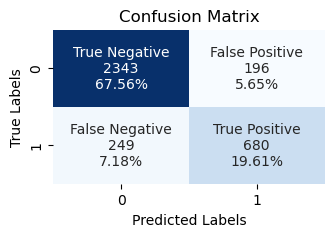




Confusion matrix

 [[2343  196]
 [ 249  680]]

True Negatives  (TN) =  2343
False Positives (FP) =  196
False Negatives (FN) =  249
True Positives  (TP) =  680


Accuracy:        0.871683967704729
Sensitivity:     0.7319698600645855
Specificity:     0.9228042536431666
Geometric Mean:  0.8218667169354122


Precision:        0.8697326954142447
Recall:           0.871683967704729
f1-score:         0.8704628154375667

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9039    0.9228    0.9133      2539
           1     0.7763    0.7320    0.7535       929

    accuracy                         0.8717      3468
   macro avg     0.8401    0.8274    0.8334      3468
weighted avg     0.8697    0.8717    0.8705      3468





The entire notebook runtime so far is 4 minutes


In [57]:
# Create an instance of the LogisticRegression model
clf = LogisticRegression()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")
        
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_lr_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
# We want to see approximately equal results from TN and TP 
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## LR hyperparameter optimization

Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best Scores: 0.8436330397381694
Cross validation scores: [0.85620053 0.84168865 0.84015852 0.84280053 0.84940555 0.82694848
 0.86261559 0.82959049 0.84412153 0.84280053]
Mean cross validation score: 0.8436330397381694
Standard Deviation cross validation score: 0.010220793401870746
Accuracy: 0.8739907727797002


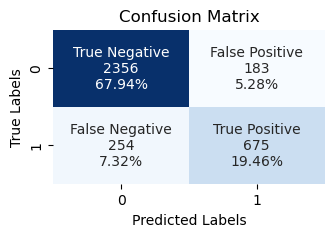




Confusion matrix

 [[2356  183]
 [ 254  675]]

True Negatives  (TN) =  2356
False Positives (FP) =  183
False Negatives (FN) =  254
True Positives  (TP) =  675


Accuracy:        0.8739907727797002
Sensitivity:     0.7265877287405813
Specificity:     0.9279243796770382
Geometric Mean:  0.8211080729554131


Precision:        0.871616557641495
Recall:           0.8739907727797002
f1-score:         0.8723562876793427

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9027    0.9279    0.9151      2539
           1     0.7867    0.7266    0.7555       929

    accuracy                         0.8740      3468
   macro avg     0.8447    0.8273    0.8353      3468
weighted avg     0.8716    0.8740    0.8724      3468





The entire notebook runtime so far is 6 minutes


In [58]:
# Create an instance of the  model
clf = LogisticRegression()

# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = LogisticRegression(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = accuracy_score(y_test_label, y_pred)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_lr_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_lr = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## Decision Tree

Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.932237600922722


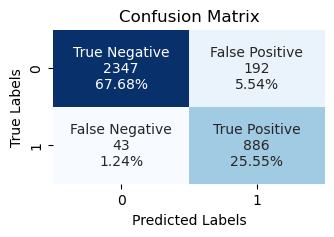




Confusion matrix

 [[2347  192]
 [  43  886]]

True Negatives  (TN) =  2347
False Positives (FP) =  192
False Negatives (FN) =  43
True Positives  (TP) =  886


Accuracy:        0.932237600922722
Sensitivity:     0.9537136706135629
Specificity:     0.924379677038204
Geometric Mean:  0.9389321247186536


Precision:        0.9391168628192332
Recall:           0.932237600922722
f1-score:         0.9337287431435265

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9820    0.9244    0.9523      2539
           1     0.8219    0.9537    0.8829       929

    accuracy                         0.9322      3468
   macro avg     0.9020    0.9390    0.9176      3468
weighted avg     0.9391    0.9322    0.9337      3468





The entire notebook runtime so far is 6 minutes


In [59]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")
        
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_dt_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## DT hyperparameter optimization

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Scores: 0.9457194591900399
Cross validation scores: [0.95118734 0.95118734 0.93791281 0.95772787 0.94848085 0.94583884
 0.9339498  0.94980185 0.94319683 0.93659181]
Mean cross validation score: 0.9455875330686677
Standard Deviation cross validation score: 0.007192182572347264
Accuracy: 0.9561707035755479


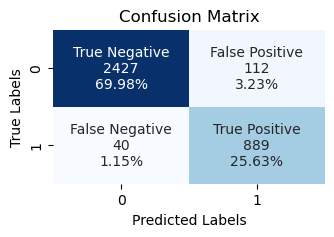




Confusion matrix

 [[2427  112]
 [  40  889]]

True Negatives  (TN) =  2427
False Positives (FP) =  112
False Negatives (FN) =  40
True Positives  (TP) =  889


Accuracy:        0.9561707035755479
Sensitivity:     0.9569429494079655
Specificity:     0.9558881449389524
Geometric Mean:  0.9564154017590839


Precision:        0.9581570167954033
Recall:           0.9561707035755479
f1-score:         0.9566730521529915

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9838    0.9559    0.9696      2539
           1     0.8881    0.9569    0.9212       929

    accuracy                         0.9562      3468
   macro avg     0.9359    0.9564    0.9454      3468
weighted avg     0.9582    0.9562    0.9567      3468





The entire notebook runtime so far is 6 minutes


In [60]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier()

# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count,n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = DecisionTreeClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = accuracy_score(y_test_label, y_pred)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_dt_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_dt = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## Decision Stump 
Decision Stump is a special case of the Decision Tree classifier with max_depth=1

The term "Decision Stump" typically refers to a decision tree with only one level, meaning it makes decisions based on a single feature. 

The main hyperparameters for a decision stump are usually the splitting criterion and the choice of the feature to split on. 

However, since decision stumps are simple, there might not be a lot of hyperparameters to optimize compared to more complex models.


Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.8261245674740484


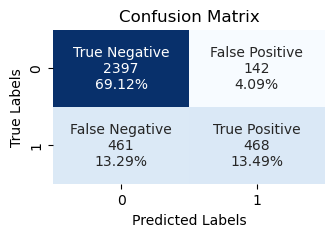




Confusion matrix

 [[2397  142]
 [ 461  468]]

True Negatives  (TN) =  2397
False Positives (FP) =  142
False Negatives (FN) =  461
True Positives  (TP) =  468


Accuracy:        0.8261245674740484
Sensitivity:     0.503767491926803
Specificity:     0.9440724694761717
Geometric Mean:  0.6896325254402915


Precision:        0.8195490764251806
Recall:           0.8261245674740484
f1-score:         0.8132429589660275

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.8387    0.9441    0.8883      2539
           1     0.7672    0.5038    0.6082       929

    accuracy                         0.8261      3468
   macro avg     0.8030    0.7239    0.7482      3468
weighted avg     0.8195    0.8261    0.8132      3468





The entire notebook runtime so far is 6 minutes


In [61]:
# Create an instance of the DecisionTreeClassifier model
clf = DecisionTreeClassifier(max_depth=1)

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")
        
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)


# save accuracy for later comparison
accuracy_ds_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

In [62]:
# check to see if there is any benefit to using Decision Stump instead of Decision Tree
if (accuracy_ds_undersampled_unoptimized < accuracy_dt_undersampled_unoptimized):
    print(f"NOTE: Decision Stump is a special case of Decision Tree with max_depth=1, but does not seem to be beneficial for this dataset.")
    print(f"Decision Tree accuracy is {accuracy_dt_undersampled_unoptimized*100:.2f}%, while Decision Stump accuracy is only {accuracy_ds_undersampled_unoptimized*100:.2f}%")

NOTE: Decision Stump is a special case of Decision Tree with max_depth=1, but does not seem to be beneficial for this dataset.
Decision Tree accuracy is 93.22%, while Decision Stump accuracy is only 82.61%


## DS hyperparameter optimization


Remember that decision stumps are very simple models, and hyperparameter tuning might not have as much impact as it would on more complex models. It's always a good practice to experiment and validate the performance on a validation set or through cross-validation.

Best Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Scores: 0.7362648700083303
Cross validation scores: [0.7414248  0.73350923 0.70937913 0.75561427 0.76089828 0.71334214
 0.74636724 0.72919419 0.74504624 0.72787318]
Mean cross validation score: 0.7362648700083303
Standard Deviation cross validation score: 0.016010316842677078
Accuracy: 0.8261245674740484


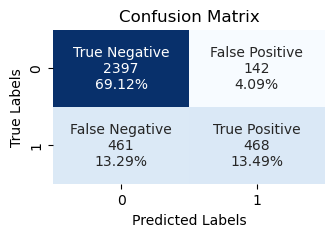




Confusion matrix

 [[2397  142]
 [ 461  468]]

True Negatives  (TN) =  2397
False Positives (FP) =  142
False Negatives (FN) =  461
True Positives  (TP) =  468


Accuracy:        0.8261245674740484
Sensitivity:     0.503767491926803
Specificity:     0.9440724694761717
Geometric Mean:  0.6896325254402915


Precision:        0.8195490764251806
Recall:           0.8261245674740484
f1-score:         0.8132429589660275

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.8387    0.9441    0.8883      2539
           1     0.7672    0.5038    0.6082       929

    accuracy                         0.8261      3468
   macro avg     0.8030    0.7239    0.7482      3468
weighted avg     0.8195    0.8261    0.8132      3468





The entire notebook runtime so far is 6 minutes


In [63]:
# Create an instance of the DecisionTreeClassifier model with max_depth=1
clf = DecisionTreeClassifier(max_depth=1)

# Define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count,n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = DecisionTreeClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = accuracy_score(y_test_label, y_pred)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ds_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_ds = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

In [64]:
# check to see if there is any benefit to using Decision Stump instead of Decision Tree
if (accuracy_ds_undersampled_optimized < accuracy_dt_undersampled_optimized):
    print(f"NOTE: Decision Stump is a special case of Decision Tree with max_depth=1, but does not seem to be beneficial for this dataset.")
    print(f"Decision Tree accuracy is {accuracy_dt_undersampled_optimized*100:.2f}%, while Decision Stump accuracy is only {accuracy_ds_undersampled_optimized*100:.2f}%")

NOTE: Decision Stump is a special case of Decision Tree with max_depth=1, but does not seem to be beneficial for this dataset.
Decision Tree accuracy is 95.62%, while Decision Stump accuracy is only 82.61%


## Random Forest Classifier

Training model with default hyperparameters of: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9512687427912342


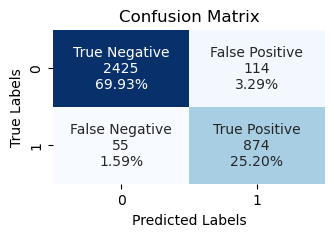




Confusion matrix

 [[2425  114]
 [  55  874]]

True Negatives  (TN) =  2425
False Positives (FP) =  114
False Negatives (FN) =  55
True Positives  (TP) =  874


Accuracy:        0.9512687427912342
Sensitivity:     0.9407965554359526
Specificity:     0.9551004332414337
Geometric Mean:  0.9479215145194917


Precision:        0.9528544476833208
Recall:           0.9512687427912342
f1-score:         0.9517322239848077

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9778    0.9551    0.9663      2539
           1     0.8846    0.9408    0.9118       929

    accuracy                         0.9513      3468
   macro avg     0.9312    0.9479    0.9391      3468
weighted avg     0.9529    0.9513    0.9517      3468





The entire notebook runtime so far is 6 minutes


In [65]:
# Create an instance of the RandomForestClassifier model
clf = RandomForestClassifier(n_jobs=-1, random_state=42)

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_rf_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## RF hyperparameter optimization

Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Scores: 0.9420206480936066
Cross validation scores: [0.95118734 0.95514512 0.94055482 0.95112285 0.94187583 0.92206077
 0.92866579 0.94451783 0.93659181 0.92866579]
Mean cross validation score: 0.9400387935992305
Standard Deviation cross validation score: 0.010453860335374906
Accuracy: 0.9521337946943483


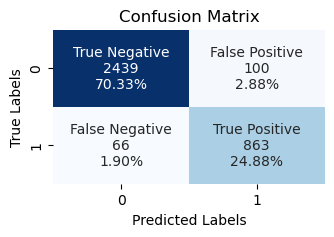




Confusion matrix

 [[2439  100]
 [  66  863]]

True Negatives  (TN) =  2439
False Positives (FP) =  100
False Negatives (FN) =  66
True Positives  (TP) =  863


Accuracy:        0.9521337946943483
Sensitivity:     0.9289558665231432
Specificity:     0.9606144151240646
Geometric Mean:  0.9446525268034791


Precision:        0.9528935481701102
Recall:           0.9521337946943483
f1-score:         0.9524025567285213

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9737    0.9606    0.9671      2539
           1     0.8962    0.9290    0.9123       929

    accuracy                         0.9521      3468
   macro avg     0.9349    0.9448    0.9397      3468
weighted avg     0.9529    0.9521    0.9524      3468





The entire notebook runtime so far is 6 minutes


In [66]:
# Create an instance of the RandomForestClassifier model
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = RandomForestClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_rf_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_rf = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

In [67]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

The entire notebook runtime so far is 6 minutes


## Naive Bayes 

Training model with default hyperparameters of: {'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
Accuracy: 0.7673010380622838


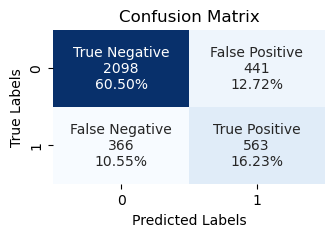




Confusion matrix

 [[2098  441]
 [ 366  563]]

True Negatives  (TN) =  2098
False Positives (FP) =  441
False Negatives (FN) =  366
True Positives  (TP) =  563


Accuracy:        0.7673010380622838
Sensitivity:     0.6060279870828849
Specificity:     0.8263095706971249
Geometric Mean:  0.7076487305414327


Precision:        0.7735878907190631
Recall:           0.7673010380622838
f1-score:         0.7700711781503033

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.8515    0.8263    0.8387      2539
           1     0.5608    0.6060    0.5825       929

    accuracy                         0.7673      3468
   macro avg     0.7061    0.7162    0.7106      3468
weighted avg     0.7736    0.7673    0.7701      3468





The entire notebook runtime so far is 6 minutes


In [68]:
# Create an instance of the model
#clf = GaussianNB()    # suitable for continuous features
#clf = MultinomialNB() # used for discrete data like word counts
clf = BernoulliNB()    # suitable for binary data, gives best accuracy for this dataset

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")
        
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_nb_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## NB hyperparameter optimization

Performing GridSearchCV
Best Parameters: {'alpha': 0.1}
Best Scores: 0.7275476380518852
Fitting the model
Cross validation scores: [0.73218997 0.73218997 0.71202114 0.74768824 0.74372523 0.69484808
 0.72919419 0.74108322 0.74108322 0.7014531 ]
Mean cross validation score: 0.7275476380518852
Standard Deviation cross validation score: 0.01752385248568137
Accuracy: 0.7678777393310265


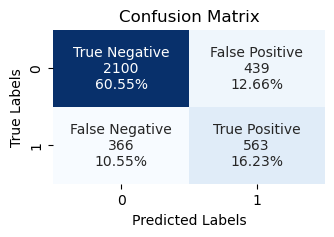




Confusion matrix

 [[2100  439]
 [ 366  563]]

True Negatives  (TN) =  2100
False Positives (FP) =  439
False Negatives (FN) =  366
True Positives  (TP) =  563


Accuracy:        0.7678777393310265
Sensitivity:     0.6060279870828849
Specificity:     0.8270972823946435
Geometric Mean:  0.7079859470154406


Precision:        0.7739759181239302
Recall:           0.7678777393310265
f1-score:         0.7705725432085907

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.8516    0.8271    0.8392      2539
           1     0.5619    0.6060    0.5831       929

    accuracy                         0.7679      3468
   macro avg     0.7067    0.7166    0.7111      3468
weighted avg     0.7740    0.7679    0.7706      3468





The entire notebook runtime so far is 6 minutes


In [69]:
# Create an instance of the model
clf = BernoulliNB()

# Define the hyperparameters to tune
# skip the sigmoid and poly kernels, rarely used
param_grid = {'alpha': [0.1, 0.01, 0.001, 0.0001]}




# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
print("Performing GridSearchCV")
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of model with the best hyperparameters
clf = BernoulliNB(**best_params)

# Fit the model to the training data
print("Fitting the model")
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_nb_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_nb = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## SVM classifier

Training model with default hyperparameters of: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy: 0.8771626297577855


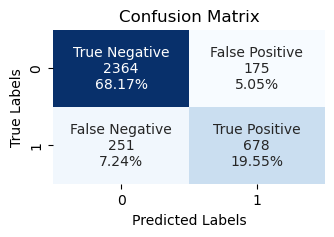




Confusion matrix

 [[2364  175]
 [ 251  678]]

True Negatives  (TN) =  2364
False Positives (FP) =  175
False Negatives (FN) =  251
True Positives  (TP) =  678


Accuracy:        0.8771626297577855
Sensitivity:     0.7298170075349839
Specificity:     0.931075226467113
Geometric Mean:  0.824326716520935


Precision:        0.8747701295675053
Recall:           0.8771626297577855
f1-score:         0.8754488715059536

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9040    0.9311    0.9173      2539
           1     0.7948    0.7298    0.7609       929

    accuracy                         0.8772      3468
   macro avg     0.8494    0.8304    0.8391      3468
weighted avg     0.8748    0.8772    0.8754      3468





The entire notebook runtime so far is 6 minutes


In [70]:
# Create an instance of the model
clf = SVC()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")
        
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_svm_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## SVM hyperparameter optimization

In [71]:
print("WARNING: SVM hyperparameter optimization is very CPU-intensive, this will take some time...")

Performing GridSearchCV
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Scores: 0.8497080894936616
Fitting the model
Cross validation scores: [0.86279683 0.8469657  0.84412153 0.85336856 0.85733157 0.83751651
 0.86129458 0.83619551 0.85204756 0.84544254]
Mean cross validation score: 0.8497080894936616
Standard Deviation cross validation score: 0.008778959925939406
Accuracy: 0.8777393310265282


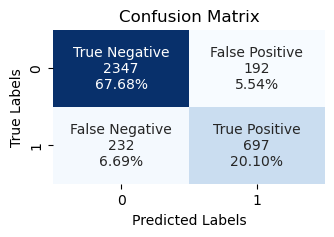




Confusion matrix

 [[2347  192]
 [ 232  697]]

True Negatives  (TN) =  2347
False Positives (FP) =  192
False Negatives (FN) =  232
True Positives  (TP) =  697


Accuracy:        0.8777393310265282
Sensitivity:     0.7502691065662002
Specificity:     0.924379677038204
Geometric Mean:  0.8327865959652604


Precision:        0.8762858632576085
Recall:           0.8777393310265282
f1-score:         0.8768720965336891

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9100    0.9244    0.9172      2539
           1     0.7840    0.7503    0.7668       929

    accuracy                         0.8777      3468
   macro avg     0.8470    0.8373    0.8420      3468
weighted avg     0.8763    0.8777    0.8769      3468





The entire notebook runtime so far is 8 minutes


In [72]:
# Create an instance of the model
clf = SVC()

# Define the hyperparameters to tune
# skip the sigmoid and poly kernels, rarely used
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}



# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
print("Performing GridSearchCV")
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of model with the best hyperparameters
clf = SVC(**best_params)

# Fit the model to the training data
print("Fitting the model")
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_svm_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_svm = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## KNN classifier 

Training model with default hyperparameters of: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.841118800461361


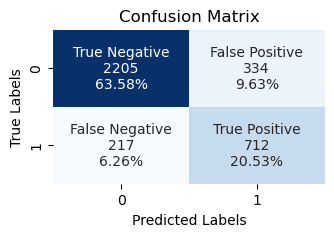




Confusion matrix

 [[2205  334]
 [ 217  712]]

True Negatives  (TN) =  2205
False Positives (FP) =  334
False Negatives (FN) =  217
True Positives  (TP) =  712


Accuracy:        0.841118800461361
Sensitivity:     0.7664155005382132
Specificity:     0.8684521465143757
Geometric Mean:  0.8158401721932433


Precision:        0.8488687444254941
Recall:           0.841118800461361
f1-score:         0.8439513782967412

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9104    0.8685    0.8889      2539
           1     0.6807    0.7664    0.7210       929

    accuracy                         0.8411      3468
   macro avg     0.7955    0.8174    0.8050      3468
weighted avg     0.8489    0.8411    0.8440      3468





The entire notebook runtime so far is 8 minutes


In [73]:
# Create an instance of the model with the desired number of neighbors (you can adjust n_neighbors)
clf = KNeighborsClassifier(n_neighbors=5)  # You can change the value of n_neighbors as needed

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_knn_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## KNN hyperparameter optimization

Best Parameters: {'n_neighbors': 30, 'weights': 'uniform'}
Best Scores: 0.8409924260115789
Cross validation scores: [0.86015831 0.82717678 0.83751651 0.84412153 0.84808454 0.8335535
 0.83883752 0.82959049 0.84412153 0.84676354]
Mean cross validation score: 0.8409924260115789
Standard Deviation cross validation score: 0.009292239313107938
Accuracy: 0.8803344867358708


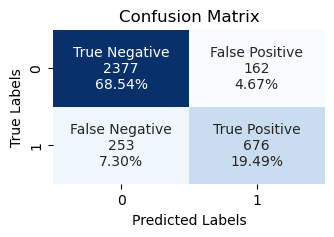




Confusion matrix

 [[2377  162]
 [ 253  676]]

True Negatives  (TN) =  2377
False Positives (FP) =  162
False Negatives (FN) =  253
True Positives  (TP) =  676


Accuracy:        0.8803344867358708
Sensitivity:     0.7276641550053822
Specificity:     0.9361953525009846
Geometric Mean:  0.8253700988632886


Precision:        0.8777860746695241
Recall:           0.8803344867358708
f1-score:         0.8783064695444817

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9038    0.9362    0.9197      2539
           1     0.8067    0.7277    0.7651       929

    accuracy                         0.8803      3468
   macro avg     0.8552    0.8319    0.8424      3468
weighted avg     0.8778    0.8803    0.8783      3468





The entire notebook runtime so far is 8 minutes


In [74]:
# Create an instance of the model
clf = KNeighborsClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_neighbors': [5,10,15,20,30],
    'weights': ['uniform', 'distance']
}



# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = KNeighborsClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_knn_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_knn = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## MLP Multi-Layer Perceptron deep neural network classifier

MLPClassifier is a class in scikit-learn that represents a Multi-layer Perceptron (MLP) classifier, which is a type of artificial neural network. 

An MLP is a feedforward neural network that consists of multiple layers of nodes (neurons) and can learn complex patterns and relationships in data. 

The MLPClassifier is specifically designed for classification tasks.

Example of all hyperparameters:
    
    mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Architecture of hidden layers
    activation='relu',             # Activation function ('relu' is common)
    solver='adam',                 # Optimization solver
    alpha=0.0001,                  # L2 penalty (regularization)
    batch_size='auto',             # Size of mini-batches ('auto' is adaptive)
    learning_rate='constant',      # Learning rate schedule
    learning_rate_init=0.001,      # Initial learning rate
    max_iter=500,                  # Maximum number of iterations
    shuffle=True,                  # Shuffle data in each iteration
    random_state=42,               # Random seed for reproducibility
    verbose=True                   # Print progress during training
)




Training model with default hyperparameters of: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Accuracy: 0.8791810841983853


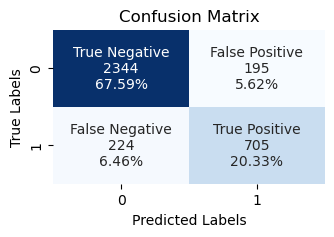




Confusion matrix

 [[2344  195]
 [ 224  705]]

True Negatives  (TN) =  2344
False Positives (FP) =  195
False Negatives (FN) =  224
True Positives  (TP) =  705


Accuracy:        0.8791810841983853
Sensitivity:     0.7588805166846071
Specificity:     0.9231981094919259
Geometric Mean:  0.8370167610827666


Precision:        0.8780986913731958
Recall:           0.8791810841983853
f1-score:         0.8785662863735355

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9128    0.9232    0.9180      2539
           1     0.7833    0.7589    0.7709       929

    accuracy                         0.8792      3468
   macro avg     0.8481    0.8410    0.8444      3468
weighted avg     0.8781    0.8792    0.8786      3468





The entire notebook runtime so far is 8 minutes


In [75]:
# Create an instance of the model 
clf = MLPClassifier()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_mlp_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## MLP hyperparameter optimization

Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 800}
Best Scores: 0.8551235086422938
Cross validation scores: [0.85751979 0.83509235 0.84280053 0.85733157 0.85601057 0.84015852
 0.85204756 0.84147952 0.85204756 0.85072655]
Mean cross validation score: 0.84852145150103
Standard Deviation cross validation score: 0.007596062065796938
Accuracy: 0.8777393310265282


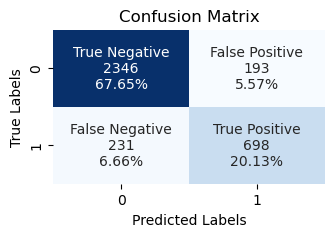




Confusion matrix

 [[2346  193]
 [ 231  698]]

True Negatives  (TN) =  2346
False Positives (FP) =  193
False Negatives (FN) =  231
True Positives  (TP) =  698


Accuracy:        0.8777393310265282
Sensitivity:     0.751345532831001
Specificity:     0.9239858211894446
Geometric Mean:  0.8332062284632018


Precision:        0.8763480638643725
Recall:           0.8777393310265282
f1-score:         0.8769170398162554

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9104    0.9240    0.9171      2539
           1     0.7834    0.7513    0.7670       929

    accuracy                         0.8777      3468
   macro avg     0.8469    0.8377    0.8421      3468
weighted avg     0.8763    0.8777    0.8769      3468





The entire notebook runtime so far is 12 minutes


In [76]:
#mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)


# Create an instance of the model
clf = MLPClassifier()

# Define the hyperparameters to tune
param_grid = {
    'hidden_layer_sizes': [(100, 50), (50, 25), (150, 100)],  #tuples for hidden layers
    'max_iter': [300, 500, 800],
    'alpha': [0.0001, 0.001, 0.01]
}


# other exaples to use in param_grid for testing
#param_grid = {
#    'hidden_layer_sizes': [(50, 25), (100, 50), (100, 100)],
#    'activation': ['relu', 'tanh'],
#    'alpha': [0.0001, 0.001, 0.01],
#    'learning_rate': ['constant', 'adaptive'],
#    'max_iter': [200, 300, 500],
#}


# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = MLPClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_mlp_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_mlp = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## GB Gradient Boosting classifier

XGboost and gradient boosting are both ensemble learning models
Gradient boosting is built into sklearn, but xgboost needs to install its own package
Let's start with gradient boosting




model = GradientBoostingClassifier(
    n_estimators=100,           # Number of boosting stages (trees)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=3,                # Maximum tree depth
    random_state=42             # Seed for reproducibility
)




Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9561707035755479


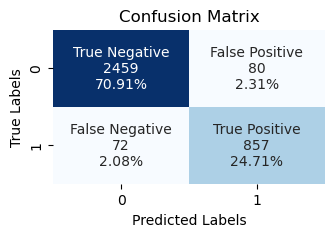




Confusion matrix

 [[2459   80]
 [  72  857]]

True Negatives  (TN) =  2459
False Positives (FP) =  80
False Negatives (FN) =  72
True Positives  (TP) =  857


Accuracy:        0.9561707035755479
Sensitivity:     0.922497308934338
Specificity:     0.9684915320992517
Geometric Mean:  0.9452147015822668


Precision:        0.9563020337132185
Recall:           0.9561707035755479
f1-score:         0.9562300777247025

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9716    0.9685    0.9700      2539
           1     0.9146    0.9225    0.9185       929

    accuracy                         0.9562      3468
   macro avg     0.9431    0.9455    0.9443      3468
weighted avg     0.9563    0.9562    0.9562      3468





The entire notebook runtime so far is 12 minutes


In [77]:
# Create an instance of the model
clf = GradientBoostingClassifier() 

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_gb_undersampled_unoptimized = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## GB hyperparameter optimization

Training model with default hyperparameters of: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'random_state': 42}
Best Scores: 0.9482286696200459
Cross validation scores: [0.95514512 0.95382586 0.93923382 0.95904888 0.94319683 0.94187583
 0.94980185 0.95904888 0.94980185 0.93130779]
Mean cross validation score: 0.9482286696200459
Standard Deviation cross validation score: 0.008667010950104338
Accuracy: 0.9550173010380623


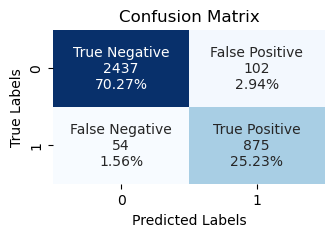




Confusion matrix

 [[2437  102]
 [  54  875]]

True Negatives  (TN) =  2437
False Positives (FP) =  102
False Negatives (FN) =  54
True Positives  (TP) =  875


Accuracy:        0.9550173010380623
Sensitivity:     0.9418729817007535
Specificity:     0.9598267034265459
Geometric Mean:  0.9508074668787396


Precision:        0.9561622586477831
Recall:           0.9550173010380623
f1-score:         0.9553690856960504

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9783    0.9598    0.9690      2539
           1     0.8956    0.9419    0.9182       929

    accuracy                         0.9550      3468
   macro avg     0.9370    0.9508    0.9436      3468
weighted avg     0.9562    0.9550    0.9554      3468





The entire notebook runtime so far is 15 minutes


In [78]:
# Create an instance of the model
clf = GradientBoostingClassifier()

default_params = clf.get_params()
print(f"Training model with default hyperparameters of: {default_params}")

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10, 100, 300], 
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'random_state': [42]
}

# Create an instance of GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_scores = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Scores:", best_scores)

# Create a new instance of the model with the best hyperparameters
clf = GradientBoostingClassifier(**best_params)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_gb_undersampled_optimized = accuracy

# save best parameters for later comparison
best_params_gb = best_params

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## XBG XGBoost eXtreme Gradient Boosting classifier

XGBoost (eXtreme Gradient Boosting) is a popular and powerful open-source machine learning library designed for speed and performance. 

It is an implementation of gradient boosting, a machine learning technique that builds a series of weak learners (typically decision trees) and combines their predictions to create a stronger, more accurate model.

XGBoost is known for its efficiency, scalability, and ability to handle diverse types of data.

XGBoost is not built into sklearn, you will need to install the package with: pip install xgboost


In this example, the xgb.DMatrix is a data structure that XGBoost uses for efficient training. 
The params dictionary contains various hyperparameters for the XGBoost model, and xgb.train is used to train the model. 
Finally, predictions are made on the test set, and the accuracy is evaluated.

In [79]:
# The xgboost library is not part of the default install of sklearn, check to see if xgboost library is installed
if 'xgboost' in sys.modules:
    print(f"Confirmed xgboost library is installed")
else:
    print(f"ERROR: xgboost library is NOT installed, please install with: pip install xgboost")



# only run the rest of the cell if the xgboost library is installed
if 'xgbboost' in sys.modules:
    # Convert data to DMatrix format (optimized data structure for XGBoost)
    dtrain = xgb.DMatrix(X_train_resampled, label=y_train_label_resampled)
    dtest  = xgb.DMatrix(X_test, label=y_test_label)

    # Set parameters for XGBoost
    params = {
        'objective': 'multi:softmax',  # Multi-class classification
        'num_class': 3,  # Number of classes
        'max_depth': 3,
        'eta': 0.1,
        'eval_metric': 'merror'  # Mean classification error
    }

    # Train the XGBoost model
    num_rounds = 100
    xgb_model = xgb.train(params, dtrain, num_rounds)

    # Make predictions on the test set
    y_pred = xgb_model.predict(dtest)

    # Convert predicted probabilities to class labels
    y_pred = [int(round(pred)) for pred in y_pred]

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy: {accuracy}")

    accuracy = clf.score(X_test, y_test_label)
    print(f"Accuracy: {accuracy}")

    # save accuracy for later comparison
    accuracy_xgb_undersampled_unoptimized = accuracy

    # call previously defined function to create confusion matrix
    cm = visualize_confusion_matrix(y_test_label, y_pred)

    # call previously defined function to create report on model precision, recall, f1-score, accuracy
    model_classification_report(cm, y_test_label, y_pred)

    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

Confirmed xgboost library is installed


## XGB hyperparameter optimization

Confirmed xgboost library is installed
Default hyperparameters are: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Adjusting hyperparameters to: 

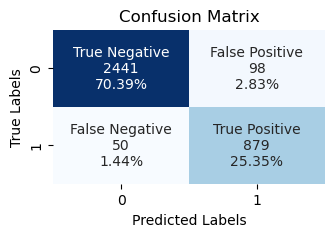




Confusion matrix

 [[2441   98]
 [  50  879]]

True Negatives  (TN) =  2441
False Positives (FP) =  98
False Negatives (FN) =  50
True Positives  (TP) =  879


Accuracy:        0.9573241061130334
Sensitivity:     0.946178686759957
Specificity:     0.9614021268215833
Geometric Mean:  0.9537600336585065


Precision:        0.9584346224078368
Recall:           0.9573241061130334
f1-score:         0.9576578505321505

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9799    0.9614    0.9706      2539
           1     0.8997    0.9462    0.9224       929

    accuracy                         0.9573      3468
   macro avg     0.9398    0.9538    0.9465      3468
weighted avg     0.9584    0.9573    0.9577      3468





The entire notebook runtime so far is 20 minutes


In [80]:
# The xgboost library is not part of the default install of sklearn, check to see if xgboost library is installed
if 'xgboost' in sys.modules:
    print(f"Confirmed xgboost library is installed")
else:
    print(f"ERROR: xgboost library is NOT installed, please install with: pip install xgboost")


# only run the rest of the cell if the xgboost library is installed
if 'xgboost' in sys.modules:

    # Create an instance of the model
    clf = xgb.XGBClassifier()

    default_params = clf.get_params()
    print(f"Default hyperparameters are: {default_params}")
    print('\n')

    # Define the hyperparameters to tune
    param_grid = {
        'objective': ['multi:softmax'],
        'num_class': [3],  # Number of classes
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'n_estimators': [50, 100, 200]
    }
    print(f"Adjusting hyperparameters to: {param_grid}")
    print('\n')

    # Use GridSearchCV to find the best hyperparameters
    print(f"Performing GridSearchCV")
    grid_search = GridSearchCV(clf, param_grid, cv=cv_count, scoring='accuracy')
    print(f"Fitting model")
    grid_search.fit(X_train_resampled, y_train_label_resampled)

    # Print the best hyperparameters
    best_params = grid_search.best_params_
    best_scores = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Scores:", best_scores)

    # Evaluate the model with the best hyperparameters on the test set
    clf = grid_search.best_estimator_
    y_pred = clf.predict(X_test)

    # final cross validation
    cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
    print(f"Cross validation scores: {cross_val_score_result}")
    print(f"Mean cross validation score: {cross_val_score_result.mean()}")
    print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy: {accuracy}")

    accuracy = clf.score(X_test, y_test_label)
    print("Accuracy:", accuracy)

    # save accuracy for later comparison
    accuracy_xgb_undersampled_optimized = accuracy

    # save best parameters for later comparison
    best_params_xgb = best_params

    # call previously defined function to create confusion matrix
    cm = visualize_confusion_matrix(y_test_label, y_pred)

    # call previously defined function to create report on model precision, recall, f1-score, accuracy
    model_classification_report(cm, y_test_label, y_pred)

    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

# Compare acccuracy of LR, DT, DS, RF, NB, SVM, KNN, MLP, GB, XGB

In [81]:
# this section compares the accuracy of different methods:

if (is_data_scaled == "yes"): 
    print(f"NOTE: This dataset has been scaled to avoid skewing the results due to large data distribution")
if (is_data_scaled == "no"): 
    print(f"NOTE: This dataset has NOT been scaled, so the results may be inaccurate!")
print('\n')
          
print(f"LR  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_lr_undersampled_unoptimized*100:.2f}%")
print(f"LR  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_lr_undersampled_optimized*100:.2f}%")
print('\n')
print(f"DT  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_dt_undersampled_unoptimized*100:.2f}%")
print(f"DT  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_dt_undersampled_optimized*100:.2f}%")
print('\n')
print(f"DS  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_ds_undersampled_unoptimized*100:.2f}%")
print(f"DS  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_ds_undersampled_optimized*100:.2f}%")
print('\n')
print(f"RF  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_rf_undersampled_unoptimized*100:.2f}%")
print(f"RF  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_rf_undersampled_optimized*100:.2f}%")
print('\n')
print(f"NB  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_nb_undersampled_unoptimized*100:.2f}%")
print(f"NB  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_nb_undersampled_optimized*100:.2f}%")
print('\n')
print(f"SVM accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_svm_undersampled_unoptimized*100:.2f}%")
print(f"SVM accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_svm_undersampled_optimized*100:.2f}%")
print('\n')
print(f"KNN accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_knn_undersampled_unoptimized*100:.2f}%")
print(f"KNN accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_knn_undersampled_optimized*100:.2f}%")
print('\n')
print(f"MLP accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_mlp_undersampled_unoptimized*100:.2f}%")
print(f"MLP accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_mlp_undersampled_optimized*100:.2f}%")
print('\n')
print(f"GB  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_gb_undersampled_unoptimized*100:.2f}%")
print(f"GB  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_gb_undersampled_optimized*100:.2f}%")
print('\n')
print(f"XGB accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_xgb_undersampled_unoptimized*100:.2f}%")
print(f"XGB accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_xgb_undersampled_optimized*100:.2f}%")
print('\n')




NOTE: This dataset has been scaled to avoid skewing the results due to large data distribution


LR  accuracy on undersampled balanced data, before hyperparameter optimimization: 87.17%
LR  accuracy on undersampled balanced data, after  hyperparameter optimimization: 87.40%


DT  accuracy on undersampled balanced data, before hyperparameter optimimization: 93.22%
DT  accuracy on undersampled balanced data, after  hyperparameter optimimization: 95.62%


DS  accuracy on undersampled balanced data, before hyperparameter optimimization: 82.61%
DS  accuracy on undersampled balanced data, after  hyperparameter optimimization: 82.61%


RF  accuracy on undersampled balanced data, before hyperparameter optimimization: 95.13%
RF  accuracy on undersampled balanced data, after  hyperparameter optimimization: 95.21%


NB  accuracy on undersampled balanced data, before hyperparameter optimimization: 76.73%
NB  accuracy on undersampled balanced data, after  hyperparameter optimimization: 76.79%


SVM

# Model training with ensemble learning
This section takes the individual ML algorithms tested earlier, then runs them through an ensemble model
The goal is to see if ensemble learning can give us higher accuracy

## Descriptions of ensemble classifiers

__Voting Classifier:__  2 methods: hard voting (majority vote), and soft voting (takes the average of predictive probabilities, takes the class with the highest average probability)

__Stacking Classifier:__ Generates a final model based on multiple base models.  Predictions in intermediate steps are used to generate meta-models.

__Boosting Classifer:__ Trains weak model, generate new model on poorly performing instances, tweak the weights to get better accuracy.  The AdaBoostClassifier is an ensemble learning algorithm that belongs to the family of boosting methods. It is specifically designed for binary classification problems but can be extended to multi-class classification. AdaBoost stands for Adaptive Boosting, and its primary goal is to combine the predictions from multiple weak classifiers to create a strong classifier.

__Bagging Classifier:__ Bagging (Bootstrap Aggregating) is an ensemble learning technique that aims to improve the stability and accuracy of machine learning models. It involves training multiple instances of the same base model on different subsets of the training data. The predictions from individual models are then combined, often by averaging or voting, to produce the final prediction.  BaggingClassifier is a powerful ensemble technique that is particularly effective when applied to base models with high variance. It offers improved generalization, stability, and robustness, but it may not be the optimal choice for all scenarios, and its effectiveness depends on the characteristics of the base model and the dataset.

__Comparison Table__

| Method   | Combines Models | Strengths                                                   | Weaknesses                              |
|----------|-----------------|-------------------------------------------------------------|-----------------------------------------|
| Voting   | Yes             | Simple, effective for balancing out model weaknesses.       | Not as sophisticated as other methods.  |
| Stacking | Yes             | Can leverage the strengths of a combination of models.      | Risk of overfitting.                    |
| Boosting | No              | Can turn a weak model into a strong one.                    | Sensitive to noisy data and outliers.   |
| Bagging  | No              | Minimizes overfitting with data with high variance          | Depends on base model performance       |




## Setup common parameters for all the EL models

In [82]:
print(f"Best parameters for LR:  {best_params_lr}")
print(f"Best parameters for DT:  {best_params_dt}")
print(f"Best parameters for DS:  {best_params_ds}")
print(f"Best parameters for RF:  {best_params_rf}")
print(f"Best parameters for NB:  {best_params_nb}")
print(f"Best parameters for SVM: {best_params_svm}")
print(f"Best parameters for KNN: {best_params_knn}")
print(f"Best parameters for MLP: {best_params_mlp}")
print(f"Best parameters for GB:  {best_params_gb}")
print(f"Best parameters for XGB: {best_params_xgb}")

Best parameters for LR:  {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for DT:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best parameters for DS:  {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best parameters for RF:  {'max_depth': 10, 'n_estimators': 100}
Best parameters for NB:  {'alpha': 0.1}
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}
Best parameters for KNN: {'n_neighbors': 30, 'weights': 'uniform'}
Best parameters for MLP: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'max_iter': 800}
Best parameters for GB:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'random_state': 42}
Best parameters for XGB: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_class': 3, 'objective': 'multi:softmax', 'subsample': 1.0}


In [83]:
# BUG alert: hardcoding these values, need to figure out how to use pragrammatic values from previous cell

# Define individual classifiers using hyperparameters calculated earlier
lr_clf  = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear')
dt_clf  = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42)
ds_clf  = DecisionTreeClassifier(criterion='gini', max_depth=1, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_clf  = RandomForestClassifier(max_depth=10, n_estimators=200)
nb_clf  = BernoulliNB(alpha=0.1)
svm_clf = SVC(C=10, kernel='rbf', probability=True)  #need probability=True for voting classifier
knn_clf = KNeighborsClassifier(n_neighbors=10, weights='uniform')
mlp_clf = MLPClassifier(hidden_layer_sizes=[50,25], max_iter=800)
gb_clf  = GradientBoostingClassifier(learning_rate=0.01, max_depth=10, n_estimators=300, random_state=42)
xgb_clf = xgb.XGBClassifier(colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=50, num_class=3, objective='multi:softmax', subsample=0.8)

print(f"Best parameters for LR:  {lr_clf}")
print(f"Best parameters for DT:  {dt_clf}")
print(f"Best parameters for RF:  {rf_clf}")
print(f"Best parameters for NB:  {nb_clf}")
print(f"Best parameters for SVM: {svm_clf}")
print(f"Best parameters for KNN: {knn_clf}")
print(f"Best parameters for MLP: {mlp_clf}")
print(f"Best parameters for GB:  {gb_clf}")
print(f"Best parameters for XGB: {xgb_clf}")

Best parameters for LR:  LogisticRegression(C=100, solver='liblinear')
Best parameters for DT:  DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       random_state=42)
Best parameters for RF:  RandomForestClassifier(max_depth=10, n_estimators=200)
Best parameters for NB:  BernoulliNB(alpha=0.1)
Best parameters for SVM: SVC(C=10, probability=True)
Best parameters for KNN: KNeighborsClassifier(n_neighbors=10)
Best parameters for MLP: MLPClassifier(hidden_layer_sizes=[50, 25], max_iter=800)
Best parameters for GB:  GradientBoostingClassifier(learning_rate=0.01, max_depth=10, n_estimators=300,
                           random_state=42)
Best parameters for XGB: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
           

## Voting classifier

In this example:

SVC, KNeighborsClassifier, and RandomForestClassifier are individual classifiers.

A VotingClassifier is created with these classifiers and a soft voting strategy. Soft voting predicts the class label based on the argmax of the sums of the predicted probabilities.

The ensemble model is trained on the training set.

Predictions are made on the test set, and the performance of the ensemble model is evaluated.

You can adjust the parameters of the individual classifiers and the VotingClassifier based on your specific needs. Note that not all classifiers support probability estimates (probability=True), so make sure to check the documentation for each classifier.

Ensemble methods like VotingClassifier are beneficial when combining diverse models that capture different aspects of the data, leading to a more robust and accurate overall model.






In [84]:
# Try the voting classifier with all the base models

# Create a VotingClassifier with 'soft' voting (uses predicted probabilities)
clf = VotingClassifier(
    estimators=[('lr', lr_clf), ('dt', dt_clf), ('rf', rf_clf), ('nb', nb_clf), ('svm', svm_clf), ('knn', knn_clf), ('mlp', mlp_clf), ('gb', gb_clf)],
    voting='soft'  # 'hard' for majority voting, 'soft' for weighted voting based on probabilities
)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ensemble_voting = accuracy

Accuracy: 0.9339677047289504


In [85]:
# Try the voting classifier with stronger learners to see if you get better accuracy

# Create a VotingClassifier with 'soft' voting (uses predicted probabilities)
clf = VotingClassifier(
    estimators=[('svm', svm_clf), ('rf', rf_clf), ('dt', dt_clf)],
    voting='soft'  # 'hard' for majority voting, 'soft' for weighted voting based on probabilities
)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ensemble_voting = accuracy

Accuracy: 0.9478085351787774


In [86]:
# Try the voting classifier with the weakest base models

# Create a VotingClassifier with 'soft' voting (uses predicted probabilities)
clf = VotingClassifier(
    estimators=[('lr', lr_clf), ('ds', ds_clf), ('nb', nb_clf), ('svm', svm_clf), ('knn', knn_clf), ('mlp', mlp_clf)],
    voting='soft'  # 'hard' for majority voting, 'soft' for weighted voting based on probabilities
)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ensemble_voting = accuracy

Accuracy: 0.8823529411764706


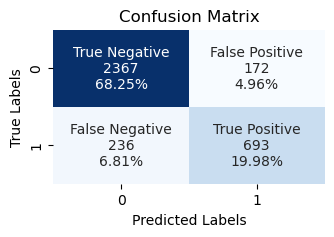




Confusion matrix

 [[2367  172]
 [ 236  693]]

True Negatives  (TN) =  2367
False Positives (FP) =  172
False Negatives (FN) =  236
True Positives  (TP) =  693


Accuracy:        0.8823529411764706
Sensitivity:     0.7459634015069968
Specificity:     0.9322567940133911
Geometric Mean:  0.8339241267287072


Precision:        0.880356552472672
Recall:           0.8823529411764706
f1-score:         0.8809865910827751

------------------------------------------------



Classification Report: 
               precision    recall  f1-score   support

           0     0.9093    0.9323    0.9207      2539
           1     0.8012    0.7460    0.7726       929

    accuracy                         0.8824      3468
   macro avg     0.8552    0.8391    0.8466      3468
weighted avg     0.8804    0.8824    0.8810      3468







In [87]:
# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)


In [88]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

The entire notebook runtime so far is 21 minutes


### Voting hyperparameter optimization

In [ ]:
# Create the VotingClassifier
clf = VotingClassifier(estimators=[('lr', lr_clf), ('svm', svm_clf), ('nb', nb_clf), ('knn', knn_clf)], voting='hard')


# Define the hyperparameters to tune
param_grid = {
    'lr__C': [0.1, 1, 10],                        # LogisticRegression hyperparameter
    'svm__C': [0.1, 1, 10],                       # SVC hyperparameter
    'knn__n_neighbors': [5, 10, 30],              # KNN hyperparameter
    'nb__alpha': [0.1, 0.01, 0.001, 0.0001]       # NB hyperparameter
}


# Use GridSearchCV for hyperparameter tuning
print(f"Performing GridSearchCV")
grid_search = GridSearchCV(clf, param_grid, cv=cv_count, scoring='accuracy')
print(f"Fitting model")
grid_search.fit(X_train_resampled, y_train_label_resampled)



    
# Validate on Test Set
clf = grid_search.best_estimator_
print(f"Found best_estimator_  {clf}")
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

# Evaluate performance on the test set
accuracy = accuracy_score(y_test_label, y_pred)
print(f"Final Accuracy on Test Set: {accuracy}")

# save accuracy for later comparison
accuracy_ensemble_voting = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")
    

Performing GridSearchCV
Fitting model


## Stacking classifier

This model (StackingClassifier) uses multiple base estimators such as LR, NB, SVC, KNN, etc.

A StackingClassifier is created with these multiple base classifiers classifiers and a meta-classifier (LogisticRegression) as the final estimator.

The stacking ensemble model is trained on the training set.

Predictions are made on the test set, and the performance of the stacking ensemble model is evaluated.

You can customize the base estimators, the final estimator, and other parameters of the StackingClassifier based on your specific needs.

In [ ]:
# Try all the base models 

# Create a stacking ensemble model with a logistic regression meta-classifier
clf = StackingClassifier(
    estimators=[('lr', lr_clf), ('dt', dt_clf), ('rf', rf_clf), ('nb', nb_clf), ('svm', svm_clf), ('knn', knn_clf), ('mlp', mlp_clf), ('gb', gb_clf)],
    final_estimator=LogisticRegression()
)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ensemble_stacking = accuracy

In [ ]:
# Try only the strongest base classifiers in the stacking classifier

clf = StackingClassifier(
    estimators=[('dt', dt_clf), ('rf', rf_clf),  ('gb', gb_clf)],
    final_estimator=LogisticRegression()
)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ensemble_stacking = accuracy

In [ ]:
# Try only the weakest base models 

# Create a stacking ensemble model with a logistic regression meta-classifier
clf = StackingClassifier(
    estimators=[('lr', lr_clf), ('nb', nb_clf), ('svm', svm_clf), ('knn', knn_clf), ('mlp', mlp_clf)],
    final_estimator=LogisticRegression()
)

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)

# save accuracy for later comparison
accuracy_ensemble_stacking = accuracy

In [ ]:
# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)


In [ ]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

### Stacking hyperparameter optimization

In [ ]:
# try optimizing base estimators with different final_estimator 

estimator_type = "weak"   #strong|weak flag to determine which base estimators to use

strong_base_estimators = [('rf', rf_clf), ('gb', gb_clf), ('dt', dt_clf)]
weak_base_estimators   = [('lr', lr_clf), ('nb', nb_clf), ('svm', svm_clf), ('knn', knn_clf), ('mlp', mlp_clf)]
final_estimators       = ['RandomForestClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier','LogisticRegression','BernoulliNB', 'SVC', 'KNN', 'MLPClassifier']
final_estimators       = ['BernoulliNB', 'SVC', 'KNN', 'MLPClassifier', 'LogisticRegression']


if (estimator_type == "strong"): base_estimators = strong_base_estimators
if (estimator_type == "weak"):   base_estimators = weak_base_estimators

for my_final_estimator in final_estimators:
    print('\n')
    print(f"Testing hyperparameter optimization with {estimator_type} base estimators {base_estimators} and final_estimator={my_final_estimator}")
    
    if (my_final_estimator == 'RandomForestClassifier'):  
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=RandomForestClassifier())
        ensemble_params = {'final_estimator__n_estimators': [50, 100, 200], 'final_estimator__max_depth': [None, 5, 10, 15]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'DecisionTreeClassifier'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=DecisionTreeClassifier())
        ensemble_params = {'final_estimator__max_depth': [None, 5, 10, 15]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'GradientBoostingClassifier'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=GradientBoostingClassifier())
        ensemble_params = {'final_estimator__n_estimators': [10, 100, 300], 'final_estimator__learning_rate': [0.1, 0.01, 0.2], 'final_estimator__max_depth': [3,5,10]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'LogisticRegression'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression())
        ensemble_params = {'final_estimator__C': [1, 10, 100], 'final_estimator__max_iter': [100, 200, 300]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'BernoulliNB'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=BernoulliNB())
        ensemble_params = {'final_estimator__alpha': [0.1, 0.001]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'SVC'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=SVC())
        ensemble_params = {'final_estimator__C': [1, 10]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'KNN'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=KNeighborsClassifier())
        ensemble_params = {'final_estimator__n_neighbors': [10,30]}  #tunable hyperparameters for final_estimator
    if (my_final_estimator == 'MLPClassifier'): 
        ensemble = StackingClassifier(estimators=base_estimators, final_estimator=MLPClassifier())
        ensemble_params = {'final_estimator__hidden_layer_sizes': [(100, 50), (50, 25), (150, 100)], 'final_estimator__max_iter': [500, 800], 'final_estimator__alpha': [0.001, 0.01]}  #tunable hyperparameters for final_estimator

        
    print(f"Performing GridSearchCV for final_estimator={my_final_estimator}")
    ensemble_grid = GridSearchCV(ensemble, ensemble_params, cv=cv_count, scoring='accuracy')
    print(f"Fitting model")
    ensemble_grid.fit(X_train_resampled, y_train_label_resampled)

    # Validate on Test Set
    clf = ensemble_grid.best_estimator_
    print(f"Found best_estimator_  {clf}")
    y_pred = clf.predict(X_test)

    # final cross validation
    cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
    print(f"Cross validation scores: {cross_val_score_result}")
    print(f"Mean cross validation score: {cross_val_score_result.mean()}")
    print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

    # Evaluate performance on the test set
    accuracy = accuracy_score(y_test_label, y_pred)
    print(f"Final Accuracy on Test Set: {accuracy}")
    
    # save accuracy for later comparison
    accuracy_ensemble_stacking = accuracy
    
    # call previously defined function to create confusion matrix
    cm = visualize_confusion_matrix(y_test_label, y_pred)

    # call previously defined function to create report on model precision, recall, f1-score, accuracy
    model_classification_report(cm, y_test_label, y_pred)

    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## Bagging classifier

In [ ]:
# Bagging can only use a single base classifier
# Use a for loop to test all the base classifiers with bagging, one base classifier at a time

base_classifiers = [lr_clf, dt_clf, rf_clf, nb_clf, svm_clf, knn_clf, mlp_clf, gb_clf, xgb_clf]  #xgb_clf causing error?
base_classifiers = [lr_clf, dt_clf, rf_clf, nb_clf, svm_clf, knn_clf, mlp_clf, gb_clf]           # all classifiers
base_classifiers = [dt_clf, rf_clf, gb_clf]                                                      # strong learners
base_classifiers = [lr_clf, nb_clf, svm_clf, knn_clf, mlp_clf]                                   # weak learners
for base_classifier in base_classifiers:
    print("\n")
    print(f"------------------------------------")
    print(f"Base classifier is {base_classifier}")
    print(f"------------------------------------")

    # Define the BaggingClassifier
    clf = BaggingClassifier(base_classifier, n_estimators=50, random_state=42)

    # Fit the model to the training data
    clf.fit(X_train_resampled, y_train_label_resampled)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy: {accuracy}")

    accuracy = clf.score(X_test, y_test_label)
    print("Accuracy:", accuracy)

    # save accuracy for later comparison
    accuracy_ensemble_bagging = accuracy
    
    # call previously defined function to create confusion matrix
    cm = visualize_confusion_matrix(y_test_label, y_pred)

    # call previously defined function to create report on model precision, recall, f1-score, accuracy
    model_classification_report(cm, y_test_label, y_pred)
    
    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")



### Bagging hyperparameter optimization

In [ ]:
# Try different weak learners with different BaggingClassifier parameters

base_estimators = ['lr', 'nb', 'svm', 'mlp', 'knn']                                  # weak learners
for base_estimator in base_estimators:
    print("\n")
    print(f"------------------------------------")
    print(f"Base estimator is {base_estimator}")
    print(f"------------------------------------")

    if (base_estimator == 'lr'):
        clf = BaggingClassifier(LogisticRegression(), random_state=42)              # Define the BaggingClassifier 
        param_grid = {'base_estimator__penalty': [best_params_lr['penalty']],       # optimized hyperparameter from base_estimator
                      'base_estimator__C': [best_params_lr['C']],                   # optimized hyperparameter from base_estimator
                      'base_estimator__solver': [best_params_lr['solver']],         # optimized hyperparameter from base_estimator
                      'base_estimator__max_iter': [best_params_lr['max_iter']],     # optimized hyperparameter from base_estimator
                      'n_estimators': [100],                                        # Number of base estimators
                      'max_samples': [1.0],                                         # The proportion of samples  to draw from X to train each base estimator
                      'max_features': [1.0]                                         # The proportion of features to draw from X to train each base estimator
                     }

    if (base_estimator == 'nb'):
        clf = BaggingClassifier(BernoulliNB(), random_state=42)                     # Define the BaggingClassifier
        param_grid = {'base_estimator__alpha': [best_params_nb['alpha']],           # optimized hyperparameter from base_estimator
                      'n_estimators': [50, 100, 200],                               # Number of base estimators
                      'max_samples': [0.5, 0.7, 1.0],                               # The proportion of samples  to draw from X to train each base estimator
                      'max_features': [0.5, 0.7, 1.0]                               # The proportion of features to draw from X to train each base estimator
                     }


    if (base_estimator == 'svm'):
        clf = BaggingClassifier(SVC(), random_state=42)                             # Define the BaggingClassifier
        param_grid = {'base_estimator__C': [best_params_svm['C']],                  # optimized hyperparameter from base_estimator
                      'base_estimator__kernel': [best_params_svm['kernel']],        # optimized hyperparameter from base_estimator
                      'n_estimators': [200],                                        # Number of base estimators
                      'max_samples': [1.0],                                         # The proportion of samples  to draw from X to train each base estimator
                      'max_features': [1.0]                                         # The proportion of features to draw from X to train each base estimator
                     }

    if (base_estimator == 'knn'):
        clf = BaggingClassifier(KNeighborsClassifier(), random_state=42)            # Define the BaggingClassifier
        param_grid = {'base_estimator__n_neighbors': [best_params_knn['n_neighbors']],       # optimized hyperparameter from base_estimator
                      'base_estimator__weights': [best_params_knn['weights']],      # optimized hyperparameter from base_estimator
                      'n_estimators': [100],                                        # Number of base estimators
                      'max_samples': [1.0],                                         # The proportion of samples  to draw from X to train each base estimator
                      'max_features': [0.5]                                         # The proportion of features to draw from X to train each base estimator
                     }

    if (base_estimator == 'mlp'):
        clf = BaggingClassifier(MLPClassifier(), random_state=42)                   # Define the BaggingClassifier
        param_grid = {'base_estimator__hidden_layer_sizes': [best_params_mlp['hidden_layer_sizes']],       # optimized hyperparameter from base_estimator
                      'base_estimator__max_iter': [best_params_mlp['max_iter']],    # optimized hyperparameter from base_estimator
                      'base_estimator__alpha': [best_params_mlp['alpha']],          # optimized hyperparameter from base_estimator
                      'n_estimators': [100],                                        # Number of base estimators
                      'max_samples': [1.0],                                         # The proportion of samples  to draw from X to train each base estimator
                      'max_features': [0.5]                                         # The proportion of features to draw from X to train each base estimator
                     }

        
    # Use GridSearchCV for hyperparameter tuning
    print(f"Performing GridSearchCV")
    grid_search = GridSearchCV(clf, param_grid, cv=cv_count, scoring='accuracy')
    print(f"Fitting model")
    grid_search.fit(X_train_resampled, y_train_label_resampled)

    
    # Print the best hyperparameters
    best_params = grid_search.best_params_
    best_scores = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Scores:", best_scores)

    # Evaluate the model with the best hyperparameters on the test set
    clf = grid_search.best_estimator_
    y_pred = clf.predict(X_test)

    # final cross validation
    cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
    print(f"Cross validation scores: {cross_val_score_result}")
    print(f"Mean cross validation score: {cross_val_score_result.mean()}")
    print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test_label, y_pred)
    print(f"Accuracy on Test Set: {accuracy}")

    accuracy = clf.score(X_test, y_test_label)
    print("Accuracy:", accuracy)

    # save accuracy for later comparison
    accuracy_ensemble_bagging = accuracy

    # save best parameters for later comparison
    best_params_ensemble_bagging = best_params
    
    # call previously defined function to create confusion matrix
    cm = visualize_confusion_matrix(y_test_label, y_pred)

    # call previously defined function to create report on model precision, recall, f1-score, accuracy
    model_classification_report(cm, y_test_label, y_pred)

    # show a running total of elapsed time for the entire notebook
    notebook_end_time = time.time()  #seconds since epoch
    print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

## Boosting Classifier

In this example:

SVC, KNeighborsClassifier,and DecisionTree are individual base classifiers.

An AdaBoostClassifier is created with these base classifiers.

The AdaBoost classifier is trained on the training set.

Predictions are made on the test set, and the performance of the AdaBoost classifier is evaluated.

You can adjust the parameters such as n_estimators and learning_rate based on your specific needs. Note that AdaBoost works best with weak learners, so base classifiers like decision trees with limited depth are commonly used.

The AdaBoostClassifier can use different base classifiers (weak learners) as its base estimator. The base_estimator parameter of the AdaBoostClassifier allows you to specify the type of weak learner to use. If not specified, the default is a decision stump (DecisionTreeClassifier(max_depth=1)).

Using RandomForestClassifier as a base estimator for AdaBoostClassifier is generally not a common practice because AdaBoost is typically used with weak learners, and Random Forests are already ensemble methods that use multiple decision trees.

However, if you still want to experiment with this combination, you can specify RandomForestClassifier as a base_estimator in AdaBoostClassifier.

Keep in mind that using RandomForestClassifier as a base estimator for AdaBoost might not provide significant advantages, as Random Forests are already powerful ensemble models. AdaBoost is often more beneficial when combined with weak learners like shallow decision trees (stumps). It's recommended to experiment with different combinations and evaluate their performance on your specific dataset.

In [ ]:
# # Create different base classifiers
# # Question: should we use the optimized hyperparameters calculated earlier?
# decision_stump = DecisionTreeClassifier(max_depth=1)
# svm_base = SVC(kernel='linear', probability=True)
# knn_base = KNeighborsClassifier(n_neighbors=5)
# dt_base = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4, min_samples_split=2, random_state=42)
# nb_base = BernoulliNB(alpha=0.1)



# # AdaBoost with Decision Stump as the base estimator
# adaboost_decision_stump = AdaBoostClassifier(
#     base_estimator=decision_stump,
#     n_estimators=50,
#     learning_rate=1.0,
#     random_state=42
# )

# # AdaBoost with SVM as the base estimator
# adaboost_svm = AdaBoostClassifier(
#     base_estimator=svm_base,
#     n_estimators=50,
#     learning_rate=1.0,
#     random_state=42
# )

# # AdaBoost with Naive Bayes as the base estimator
# adaboost_nb = AdaBoostClassifier(
#     base_estimator=nb_base,
#     n_estimators=50,
#     learning_rate=1.0,
#     random_state=42
# )

# # using KNN generates an error because KNeighborsClassifier doesn't support sample_weight
# # https://stackoverflow.com/questions/18306416/adaboostclassifier-with-different-base-learners
# # AdaBoost with KNN as the base estimator
# adaboost_knn = AdaBoostClassifier(
#     base_estimator=knn_base,
#     n_estimators=50,
#     learning_rate=1.0,
#     random_state=42
# )


# ## AdaBoost with RF as the base estimator  (usually not recommended, see previous cell explanation)
# #adaboost_rf = AdaBoostClassifier(
# #    base_estimator=rf_base,
# #    n_estimators=50,
# #    learning_rate=1.0,
# #    random_state=42
# #)


# # Question: what does "zip" mean in the following section?
# # Question: the labels in the next section never seem to get displayed on the screen
# # Question: do we get a final or averaged accuray reading from each classifier in the for loop?
# # Fit and evaluate the classifiers
# #for clf, name in zip([adaboost_decision_stump, adaboost_svm, adaboost_knn, adaboost_rf], ['AdaBoost with Decision Stump', 'AdaBoost with SVM', 'AdaBoost with KNN', 'AdaBoost with RF']):
# #for clf, name in zip([adaboost_decision_stump, adaboost_svm, adaboost_rf], ['AdaBoost with Decision Stump', 'AdaBoost with SVM', 'AdaBoost with RF']):
# #for clf, name in zip([adaboost_decision_stump, adaboost_svm, adaboost_knn], ['AdaBoost with Decision Stump', 'AdaBoost with SVM', 'AdaBoost with KNN']):
# # for clf, name in zip([adaboost_decision_stump], ['AdaBoost with Decision Stump']):
# for clf, name in zip([adaboost_lr, adaboost_nb, adaboost_svm, adaboost_decision_stump], ['AdaBoost with LR', 'AdaBoost with NB', 'AdaBoost with SVM', 'AdaBoost with Decision Stump']):
#     print("Starting to fit model:", name)

#     # Train the ensemble classfier
#     clf.fit(X_train_resampled, y_train_label_resampled)
 
#     # Make predictions on the test set
#     y_pred = clf.predict(X_test)

#     # Evaluate the model
#     accuracy = clf.score(X_test, y_test_label)
#     print("Accuracy:", accuracy)
#     print('\n')

#     # save accuracy for later comparison
#     accuracy_ensemble_boosting = accuracy



In [ ]:
# AdaBoostClassifier with multiple base classifiers

# Define multiple base classifiers
base_classifiers = [
    #DecisionTreeClassifier(max_depth=1),  # Decision stump
    LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear'),
    BernoulliNB(alpha=0.1),
    SVC(kernel='linear', C=0.1),  # Support Vector Machine with linear kernel
    KNeighborsClassifier(n_neighbors=10, weights='uniform'),
    MLPClassifier(hidden_layer_sizes=[50,25], max_iter=800)
]


# Create the AdaBoostClassifier, setting base_estimator=None because we will add multiple base_classifiers in the next step
clf = AdaBoostClassifier(base_estimator=None, n_estimators=50, random_state=42)

# Set the base classifiers as the base_estimator
clf.base_estimator_ = base_classifiers

# Fit the model to the training data
clf.fit(X_train_resampled, y_train_label_resampled)



# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test_label, y_pred)
print(f"Accuracy: {accuracy}")

accuracy = clf.score(X_test, y_test_label)
print("Accuracy:", accuracy)
print('\n')

# save accuracy for later comparison
accuracy_ensemble_boosting = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

### Boosting hyperparameter optimization

In [ ]:
print(f"Performing hyperparameter optimization for AdaBoostClassifier")

# Define multiple base classifiers
base_classifiers = [
    #DecisionTreeClassifier(max_depth=1),  # Decision stump
    LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear'),
    BernoulliNB(alpha=0.1),
    SVC(kernel='linear', C=0.1),  # Support Vector Machine with linear kernel
    KNeighborsClassifier(n_neighbors=10, weights='uniform'),
    MLPClassifier(hidden_layer_sizes=[50,25], max_iter=800)
]


# Define the hyperparameters to tune for AdaBoostClassifier
param_grid = {
    'n_estimators': [50, 100, 200],                # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 1.0]              # Weight applied to each classifier
}

# Create the AdaBoostClassifier, setting base_estimator=None because we will add multiple base_classifiers in the next step
clf = AdaBoostClassifier(base_estimator=None, random_state=42)

# Set the base classifiers as the base_estimator
clf.base_estimator_ = base_classifiers

# Use GridSearchCV for hyperparameter tuning
print(f"Performing GridSearchCV")
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
print(f"Fitting model")
grid_search.fit(X_train_resampled, y_train_label_resampled)

# Perform cross-validation and return both scores and standard deviations


# Validate on Test Set
clf = grid_search.best_estimator_
print(f"Found best_estimator_  {clf}")
y_pred = clf.predict(X_test)

# final cross validation
cross_val_score_result = cross_val_score(clf, X_train_resampled, y_train_label_resampled, cv=cv_count)
print(f"Cross validation scores: {cross_val_score_result}")
print(f"Mean cross validation score: {cross_val_score_result.mean()}")
print(f"Standard Deviation cross validation score: {cross_val_score_result.std()}")


# Evaluate the accuracy
accuracy = accuracy_score(y_test_label, y_pred)
print(f"Final Accuracy on Test Set: {accuracy}")
# This method of calculating accuracy generates an error with AdaBoostClassifier
#accuracy = clf.score(X_test, y_test_label)
#print("Accuracy:", accuracy)
#print('\n')
    
# save accuracy for later comparison
accuracy_ensemble_boosting = accuracy

# call previously defined function to create confusion matrix
cm = visualize_confusion_matrix(y_test_label, y_pred)

# call previously defined function to create report on model precision, recall, f1-score, accuracy
model_classification_report(cm, y_test_label, y_pred)

# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")

# Comparison of all models

In [ ]:
print(f"LR  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_lr_undersampled_unoptimized*100:.2f}%")
print(f"LR  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_lr_undersampled_optimized*100:.2f}%")
print('\n')
print(f"DT  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_dt_undersampled_unoptimized*100:.2f}%")
print(f"DT  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_dt_undersampled_optimized*100:.2f}%")
print('\n')
print(f"DS  accuracy on undersampled balanced data, without hyperparameter optimimization: {accuracy_ds_undersampled_unoptimized*100:.2f}%")
print(f"DS  accuracy on undersampled balanced data, with    hyperparameter optimimization: {accuracy_ds_undersampled_optimized*100:.2f}%")
print('\n')
print(f"RF  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_rf_undersampled_unoptimized*100:.2f}%")
print(f"RF  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_rf_undersampled_optimized*100:.2f}%")
print('\n')
print(f"NB  accuracy on undersampled balanced data, without hyperparameter optimimization: {accuracy_nb_undersampled_unoptimized*100:.2f}%")
print(f"NB  accuracy on undersampled balanced data, with    hyperparameter optimimization: {accuracy_nb_undersampled_optimized*100:.2f}%")
print('\n')
print(f"SVM accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_svm_undersampled_unoptimized*100:.2f}%")
print(f"SVM accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_svm_undersampled_optimized*100:.2f}%")
print('\n')
print(f"KNN accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_knn_undersampled_unoptimized*100:.2f}%")
print(f"KNN accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_knn_undersampled_optimized*100:.2f}%")
print('\n')
print(f"MLP accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_mlp_undersampled_unoptimized*100:.2f}%")
print(f"MLP accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_mlp_undersampled_optimized*100:.2f}%")
print('\n')
print(f"GB  accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_gb_undersampled_unoptimized*100:.2f}%")
print(f"GB  accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_gb_undersampled_optimized*100:.2f}%")
print('\n')
print(f"XGB accuracy on undersampled balanced data, before hyperparameter optimimization: {accuracy_xgb_undersampled_unoptimized*100:.2f}%")
print(f"XGB accuracy on undersampled balanced data, after  hyperparameter optimimization: {accuracy_xgb_undersampled_optimized*100:.2f}%")
print('\n')
print(f"Ensemble voting   accuracy on undersampled balanced data, after hyperparameter optimimization: {accuracy_ensemble_voting*100:.2f}%")
print(f"Ensemble stacking accuracy on undersampled balanced data, after hyperparameter optimimization: {accuracy_ensemble_stacking*100:.2f}%")
print(f"Ensemble bagging  accuracy on undersampled balanced data, after hyperparameter optimimization: {accuracy_ensemble_bagging*100:.2f}%")
print(f"Ensemble boosting accuracy on undersampled balanced data, after hyperparameter optimimization: {accuracy_ensemble_boosting*100:.2f}%")



In [ ]:
# show a running total of elapsed time for the entire notebook
notebook_end_time = time.time()  #seconds since epoch
print(f"The entire notebook runtime so far is {(notebook_end_time-notebook_start_time)/60:.0f} minutes")